### Learn all based on counts

In [1]:
import pandas as pd
import numpy as np
import re
import csv
import sys

import time
import random
import distance
import random
import dynet as dy
import _dynet
import json
import time
from datetime import datetime

np.set_printoptions(threshold=np.nan)
dyparams = dy.DynetParams()
dyparams.set_mem(4096)

In [2]:
df = pd.read_csv('finale.txt', delimiter='\t', header=None)
df.columns = ['word1', 'word2', 'counts']

In [3]:
new_df = df[df.word1 != df.word2]

In [4]:
new_df.head()

,word1,word2,counts
0,20/400,betimol,125
1,fusidic acid,ondansetron,101
2,right ventricular hypertrophy,emotional distress,156
3,methylcellulose,seroquel,129
4,mannitol,patient date of birth,1046


In [5]:
def read_singleton_dict(dictionary_dir):
    dic, count, unigram = {}, 0, []
    with open(dictionary_dir, 'r') as file:
        lines = file.readlines()
        for row in lines:
            line = row.split('\t')
            dic[line[0].strip()] = [int(line[1].strip()), count]
            unigram.append(count)
            count += 1
        return (dic, unigram)

In [6]:
path = '2_Singleton_Frequency_Counts/singlets_concepts_perBin_1d.txt'
singleton, unigram_table = read_singleton_dict(path)

In [7]:
def read_cofreq_dict(dictionary_dir):
    dic = {}
    with open(dictionary_dir, 'r') as file:
        lines = file.readlines()
        for row in lines:
            line = row.split('\t')
            dic[(line[0].strip(), line[1].strip()) ] = int(line[2].strip())
        return dic

In [8]:
path = '1_Cofrequency_Counts/cofreqs_concepts_perBin_1d.txt'
cofreq = read_cofreq_dict(path)

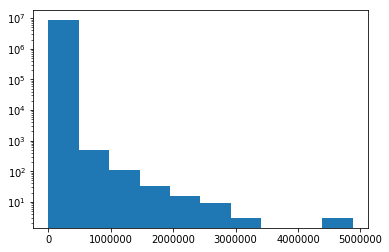

In [9]:
from matplotlib import pyplot as plt

plt.hist(cofreq.values(), log=True)
plt.show()

In [10]:
def build_training_data():
    training_data = []
    for sent_a, sent_b in cofreq.keys():
        counts = cofreq[(sent_a, sent_b)]
        if sent_a != sent_b:
            indexA = singleton[sent_a][1]
            indexB = singleton[sent_b][1]
            [training_data.append([indexA, indexB]) for _ in range(int(np.log(counts)))]#range(min(counts, min(counts, 10000)))]
    return training_data

In [11]:
training_data = build_training_data()

In [12]:
def is_valid_cuis(unigram, indexs, positive_cui):
    for i in indexs:
        if (unigram[i] == positive_cui[0]) or (unigram[i] == positive_cui[1]) :
            return False
    return True

def get_negative_sample_cuis(unigram, sample_size, positive_cui):
    population = range(len(unigram))
    indexs = random.sample(population, sample_size)
    cuis = []
    while not is_valid_cuis(unigram, indexs, positive_cui):
        indexs = random.sample(population, sample_size)
    for i in indexs:
        cuis.append(unigram[i])
    return cuis

def insert_negative_sample(training_data, unigram, sample_size):
    for i in range(len(training_data)):
        # drop the old negative samples first
        word_list = training_data[i][:2]
        negative_samples = get_negative_sample_cuis(unigram, sample_size, word_list)
        training_data[i] = word_list + negative_samples

### Helper

In [13]:
def get_duration(start_time):
    end_time = datetime.now()
    return 'Duration: {}'.format(end_time - start_time)

### Dynet Network

In [14]:
# create a class encapsulating the network
class OurNetwork(object):
    def __init__(self, pc, dictionary):
        self.dict_size = len(dictionary)
        self.lookup_hidden = pc.add_lookup_parameters((self.dict_size, word_vector_size))
        self.lookup_output = pc.add_lookup_parameters((self.dict_size, word_vector_size))
        print('Create Network with word vector size: ' + str(word_vector_size))

    def __call__(self, inputs):
        # inputs: [input word, observed word, negative sample 1, negative sample 2...]
        input_word = inputs[0]
        observed_word = inputs[1]
        
        loss = dy.log(dy.logistic(self.get_dot_product(input_word, observed_word)))
        for negative_sample in inputs[2:]:
            loss += dy.log(dy.logistic(-self.get_dot_product(input_word, negative_sample)))
        return -loss
    
    def get_dot_product(self, wordA, wordB):
        return dy.dot_product(self.lookup_hidden[wordA], self.lookup_output[wordB])
    
    def create_network_return_loss(self, inputs):
        dy.renew_cg()
        return self(inputs)

In [15]:
word_vector_size = 300
m = dy.ParameterCollection()

# create network
network = OurNetwork(m, singleton)

Create Network with word vector size: 300


In [16]:
# create trainer
trainer = dy.SimpleSGDTrainer(m)

In [17]:
negative_sample_size = 3
print('Start training with negative sample size: ' + str(negative_sample_size))

total_loss = 0
global seen_instances, epoch
ts = int(time.time())
epoch = 1

Start training with negative sample size: 3


In [18]:
def run_iteration(it_num):
    seen_instances, total_loss = 0, 0
    start_time = datetime.now()
    print('Running Iteration: ' + str(it_num))
    
    np.random.shuffle(training_data)
    print('Finish shuffling data ' + get_duration(start_time))
    
    insert_negative_sample(training_data, unigram_table, negative_sample_size)
    print('Finish inserting negative samples' + get_duration(start_time))
    
    for word_list in training_data:
        seen_instances += 1
        loss = network.create_network_return_loss(word_list)
        total_loss += loss.value()
        loss.backward()
        trainer.update()
        if seen_instances > 1 and seen_instances % 10000 == 0:
            print("average loss is: " + str(total_loss / seen_instances) + ' '\
                  + get_duration(start_time) + ' ' + str(seen_instances))

In [ ]:
seen_instances = 0
while True:
    run_iteration(epoch)
    epoch += 1
    if epoch == 11:
        save_embedding(network.lookup_hidden, ts-1)
    else:save_embedding(network.lookup_hidden, ts)

Running Iteration: 4
Finish shuffling data Duration: 0:00:20.890782
Finish inserting negative samplesDuration: 0:05:08.033006
average loss is: 1.2223328096086188 Duration: 0:05:08.544927 10000
average loss is: 1.2258485907452377 Duration: 0:05:08.962121 20000
average loss is: 1.217686163421962 Duration: 0:05:09.364018 30000
average loss is: 1.211182335937617 Duration: 0:05:09.780938 40000
average loss is: 1.2049719424894996 Duration: 0:05:10.182402 50000
average loss is: 1.2027102155065539 Duration: 0:05:10.587512 60000
average loss is: 1.2052615125676103 Duration: 0:05:10.988802 70000
average loss is: 1.209458516715047 Duration: 0:05:11.390245 80000
average loss is: 1.2082275846337367 Duration: 0:05:11.807409 90000
average loss is: 1.210723290232245 Duration: 0:05:12.208588 100000
average loss is: 1.2103493916932613 Duration: 0:05:12.626727 110000
average loss is: 1.2122430950258667 Duration: 0:05:13.028294 120000
average loss is: 1.210736454774597 Duration: 0:05:13.429838 130000
aver

average loss is: 1.2151116362564176 Duration: 0:05:57.141729 1200000
average loss is: 1.2152877456716527 Duration: 0:05:57.539509 1210000
average loss is: 1.2154769661336968 Duration: 0:05:57.952426 1220000
average loss is: 1.2152700093121713 Duration: 0:05:58.349609 1230000
average loss is: 1.2154204091472416 Duration: 0:05:58.763374 1240000
average loss is: 1.2155036168222333 Duration: 0:05:59.176456 1250000
average loss is: 1.2154686322564212 Duration: 0:05:59.573711 1260000
average loss is: 1.2152652349225974 Duration: 0:05:59.986512 1270000
average loss is: 1.2154383239652922 Duration: 0:06:00.399363 1280000
average loss is: 1.2154597213601999 Duration: 0:06:00.812747 1290000
average loss is: 1.2156602950134132 Duration: 0:06:01.209944 1300000
average loss is: 1.2157461665386453 Duration: 0:06:01.623045 1310000
average loss is: 1.2159688278419096 Duration: 0:06:02.035824 1320000
average loss is: 1.2160110540428417 Duration: 0:06:02.448603 1330000
average loss is: 1.216101198745484

average loss is: 1.2187628140851363 Duration: 0:06:46.409251 2400000
average loss is: 1.218762519530898 Duration: 0:06:46.822330 2410000
average loss is: 1.2188018363940007 Duration: 0:06:47.219305 2420000
average loss is: 1.2188916398099856 Duration: 0:06:47.632370 2430000
average loss is: 1.219033875666429 Duration: 0:06:48.061111 2440000
average loss is: 1.2190647378611696 Duration: 0:06:48.474161 2450000
average loss is: 1.2189757316709025 Duration: 0:06:48.871395 2460000
average loss is: 1.2190579298392863 Duration: 0:06:49.284150 2470000
average loss is: 1.2190902281882168 Duration: 0:06:49.682464 2480000
average loss is: 1.2191031018145346 Duration: 0:06:50.095320 2490000
average loss is: 1.2192064526070994 Duration: 0:06:50.492393 2500000
average loss is: 1.2192557557198787 Duration: 0:06:50.905170 2510000
average loss is: 1.2192638370616575 Duration: 0:06:51.302380 2520000
average loss is: 1.2193091376995187 Duration: 0:06:51.715147 2530000
average loss is: 1.2193307638583266 

average loss is: 1.2209428972017409 Duration: 0:07:35.322879 3600000
average loss is: 1.2210035912249027 Duration: 0:07:35.736256 3610000
average loss is: 1.221038557573775 Duration: 0:07:36.150714 3620000
average loss is: 1.2210358007887974 Duration: 0:07:36.563801 3630000
average loss is: 1.2210145779927395 Duration: 0:07:36.960957 3640000
average loss is: 1.220969579748439 Duration: 0:07:37.389551 3650000
average loss is: 1.2210681431799388 Duration: 0:07:37.786795 3660000
average loss is: 1.2210524991845004 Duration: 0:07:38.203402 3670000
average loss is: 1.2209910308515304 Duration: 0:07:38.601058 3680000
average loss is: 1.2209699983230862 Duration: 0:07:38.998155 3690000
average loss is: 1.220998534302473 Duration: 0:07:39.411024 3700000
average loss is: 1.2209888419135455 Duration: 0:07:39.824061 3710000
average loss is: 1.2209727354673294 Duration: 0:07:40.236728 3720000
average loss is: 1.2209220183189264 Duration: 0:07:40.634165 3730000
average loss is: 1.2209744554889426 D

average loss is: 1.2219174352691449 Duration: 0:08:24.139173 4800000
average loss is: 1.2218873291812904 Duration: 0:08:24.536932 4810000
average loss is: 1.2219241775717573 Duration: 0:08:24.949771 4820000
average loss is: 1.221904360671182 Duration: 0:08:25.346993 4830000
average loss is: 1.2219072509307802 Duration: 0:08:25.759784 4840000
average loss is: 1.2218983339818426 Duration: 0:08:26.172659 4850000
average loss is: 1.221902366436407 Duration: 0:08:26.570003 4860000
average loss is: 1.2219175467854013 Duration: 0:08:26.983009 4870000
average loss is: 1.2218794783594047 Duration: 0:08:27.380398 4880000
average loss is: 1.2218969052481645 Duration: 0:08:27.793064 4890000
average loss is: 1.221876762208794 Duration: 0:08:28.205720 4900000
average loss is: 1.221966110355019 Duration: 0:08:28.618619 4910000
average loss is: 1.221936812288084 Duration: 0:08:29.015907 4920000
average loss is: 1.2218956369862943 Duration: 0:08:29.428655 4930000
average loss is: 1.2219524710566252 Dur

average loss is: 1.2230278361413334 Duration: 0:09:12.947307 6000000
average loss is: 1.2229917229320404 Duration: 0:09:13.344860 6010000
average loss is: 1.2230347015384722 Duration: 0:09:13.774209 6020000
average loss is: 1.2230346504747558 Duration: 0:09:14.179568 6030000
average loss is: 1.2230322664616589 Duration: 0:09:14.576725 6040000
average loss is: 1.2230981422637996 Duration: 0:09:14.989768 6050000
average loss is: 1.2230995308971535 Duration: 0:09:15.387018 6060000
average loss is: 1.2230996140065502 Duration: 0:09:15.799927 6070000
average loss is: 1.2230807470686962 Duration: 0:09:16.212982 6080000
average loss is: 1.223083461546923 Duration: 0:09:16.610430 6090000
average loss is: 1.2230520957988964 Duration: 0:09:17.008181 6100000
average loss is: 1.2230618604243837 Duration: 0:09:17.421142 6110000
average loss is: 1.22305862226891 Duration: 0:09:17.818304 6120000
average loss is: 1.2230654903530143 Duration: 0:09:18.231323 6130000
average loss is: 1.2231069830542831 D

average loss is: 1.2236610598873083 Duration: 0:10:01.889164 7200000
average loss is: 1.2236858240821624 Duration: 0:10:02.286795 7210000
average loss is: 1.2236988719689552 Duration: 0:10:02.699959 7220000
average loss is: 1.2236498757604422 Duration: 0:10:03.097210 7230000
average loss is: 1.2236617928834403 Duration: 0:10:03.510000 7240000
average loss is: 1.2236863646842342 Duration: 0:10:03.907209 7250000
average loss is: 1.22370602449327 Duration: 0:10:04.319935 7260000
average loss is: 1.223736141033365 Duration: 0:10:04.717344 7270000
average loss is: 1.2237488121217626 Duration: 0:10:05.134260 7280000
average loss is: 1.223757867569574 Duration: 0:10:05.531568 7290000
average loss is: 1.223785988977405 Duration: 0:10:05.928787 7300000
average loss is: 1.2237681547241237 Duration: 0:10:06.341836 7310000
average loss is: 1.2237687820161587 Duration: 0:10:06.739745 7320000
average loss is: 1.2237513334470167 Duration: 0:10:07.152453 7330000
average loss is: 1.2237570689037736 Dur

average loss is: 1.2240989998169225 Duration: 0:10:50.697046 8400000
average loss is: 1.2240901030560967 Duration: 0:10:51.110067 8410000
average loss is: 1.2240750978274357 Duration: 0:10:51.507453 8420000
average loss is: 1.2240888979623183 Duration: 0:10:51.920343 8430000
average loss is: 1.224097839855428 Duration: 0:10:52.333367 8440000
average loss is: 1.2240836909085593 Duration: 0:10:52.734839 8450000
average loss is: 1.224101722679564 Duration: 0:10:53.147700 8460000
average loss is: 1.2240720356333112 Duration: 0:10:53.545585 8470000
average loss is: 1.2241009661009692 Duration: 0:10:53.974343 8480000
average loss is: 1.2241041316221604 Duration: 0:10:54.387235 8490000
average loss is: 1.2241106370203068 Duration: 0:10:54.799981 8500000
average loss is: 1.2241279447143363 Duration: 0:10:55.197148 8510000
average loss is: 1.2241264192300214 Duration: 0:10:55.610085 8520000
average loss is: 1.2241459831458166 Duration: 0:10:56.007599 8530000
average loss is: 1.2241379689626715 

average loss is: 1.224519853828638 Duration: 0:11:39.618028 9600000
average loss is: 1.2245107656663003 Duration: 0:11:40.047118 9610000
average loss is: 1.224504228523786 Duration: 0:11:40.464036 9620000
average loss is: 1.2244871504969521 Duration: 0:11:40.861068 9630000
average loss is: 1.2245048962214098 Duration: 0:11:41.273862 9640000
average loss is: 1.2245169878674103 Duration: 0:11:41.675567 9650000
average loss is: 1.2245336147247103 Duration: 0:11:42.088380 9660000
average loss is: 1.2245289831950208 Duration: 0:11:42.485625 9670000
average loss is: 1.2245374723600944 Duration: 0:11:42.882931 9680000
average loss is: 1.224571076438524 Duration: 0:11:43.295820 9690000
average loss is: 1.2245596479520664 Duration: 0:11:43.708509 9700000
average loss is: 1.2245660239833687 Duration: 0:11:44.137251 9710000
average loss is: 1.224573375055592 Duration: 0:11:44.534312 9720000
average loss is: 1.2245684800255947 Duration: 0:11:44.947146 9730000
average loss is: 1.2245929137670593 Du

average loss is: 1.225165134752037 Duration: 0:12:28.221528 10790000
average loss is: 1.2251820572651229 Duration: 0:12:28.619285 10800000
average loss is: 1.2251727960672527 Duration: 0:12:29.032239 10810000
average loss is: 1.225179686516629 Duration: 0:12:29.429575 10820000
average loss is: 1.2251738534367227 Duration: 0:12:29.842609 10830000
average loss is: 1.2251882748950433 Duration: 0:12:30.240054 10840000
average loss is: 1.22518381500204 Duration: 0:12:30.637734 10850000
average loss is: 1.225180784371484 Duration: 0:12:31.066428 10860000
average loss is: 1.22516709290571 Duration: 0:12:31.463466 10870000
average loss is: 1.2251424703348688 Duration: 0:12:31.876450 10880000
average loss is: 1.2251423879214736 Duration: 0:12:32.273485 10890000
average loss is: 1.2251562734519545 Duration: 0:12:32.686922 10900000
average loss is: 1.2251527408718472 Duration: 0:12:33.099774 10910000
average loss is: 1.2251805008422567 Duration: 0:12:33.512678 10920000
average loss is: 1.22515727

average loss is: 1.2256599836856636 Duration: 0:13:16.306602 11970000
average loss is: 1.2256638856811939 Duration: 0:13:16.704027 11980000
average loss is: 1.2256664450663288 Duration: 0:13:17.116905 11990000
average loss is: 1.2256815750515209 Duration: 0:13:17.545533 12000000
average loss is: 1.2256822102390432 Duration: 0:13:17.958365 12010000
average loss is: 1.2256925286149487 Duration: 0:13:18.355652 12020000
average loss is: 1.2256883090812682 Duration: 0:13:18.753069 12030000
average loss is: 1.2256764999348437 Duration: 0:13:19.165942 12040000
average loss is: 1.2256789980864768 Duration: 0:13:19.586597 12050000
average loss is: 1.2256884867817455 Duration: 0:13:19.983775 12060000
average loss is: 1.2256704631919317 Duration: 0:13:20.381166 12070000
average loss is: 1.2256734909550557 Duration: 0:13:20.795044 12080000
average loss is: 1.2256887635895137 Duration: 0:13:21.192321 12090000
average loss is: 1.2256812519224485 Duration: 0:13:21.605373 12100000
average loss is: 1.2

average loss is: 1.2260903933607223 Duration: 0:14:04.296842 13150000
average loss is: 1.2260869864506356 Duration: 0:14:04.694353 13160000
average loss is: 1.226095669285076 Duration: 0:14:05.091559 13170000
average loss is: 1.226104372184071 Duration: 0:14:05.504406 13180000
average loss is: 1.2261328066009238 Duration: 0:14:05.917282 13190000
average loss is: 1.2261295050897447 Duration: 0:14:06.330476 13200000
average loss is: 1.2261280527211418 Duration: 0:14:06.727684 13210000
average loss is: 1.2261120756032708 Duration: 0:14:07.140503 13220000
average loss is: 1.2261012012320405 Duration: 0:14:07.538268 13230000
average loss is: 1.2261013927170148 Duration: 0:14:07.951357 13240000
average loss is: 1.226129576082225 Duration: 0:14:08.379727 13250000
average loss is: 1.2261124320680818 Duration: 0:14:08.792492 13260000
average loss is: 1.2260945727355315 Duration: 0:14:09.189969 13270000
average loss is: 1.2261035406132095 Duration: 0:14:09.602973 13280000
average loss is: 1.2260

average loss is: 1.2264362518605538 Duration: 0:14:52.293410 14330000
average loss is: 1.2264654246300388 Duration: 0:14:52.722079 14340000
average loss is: 1.2264680400952717 Duration: 0:14:53.119187 14350000
average loss is: 1.2264706383448756 Duration: 0:14:53.532094 14360000
average loss is: 1.2264758674633474 Duration: 0:14:53.929925 14370000
average loss is: 1.2264665940375792 Duration: 0:14:54.327759 14380000
average loss is: 1.2264670720736428 Duration: 0:14:54.756414 14390000
average loss is: 1.2264694534489875 Duration: 0:14:55.169390 14400000
average loss is: 1.226460774479097 Duration: 0:14:55.582579 14410000
average loss is: 1.2264751647607002 Duration: 0:14:55.980034 14420000
average loss is: 1.2264843926654516 Duration: 0:14:56.381236 14430000
average loss is: 1.2265046216112652 Duration: 0:14:56.793970 14440000
average loss is: 1.226526159637634 Duration: 0:14:57.206806 14450000
average loss is: 1.226537072916848 Duration: 0:14:57.607405 14460000
average loss is: 1.2265

average loss is: 1.2267244726014872 Duration: 0:15:40.320521 15510000
average loss is: 1.2267377201352374 Duration: 0:15:40.718829 15520000
average loss is: 1.226736813593777 Duration: 0:15:41.116175 15530000
average loss is: 1.2267161049857664 Duration: 0:15:41.528782 15540000
average loss is: 1.2267211247037404 Duration: 0:15:41.926038 15550000
average loss is: 1.226730283925592 Duration: 0:15:42.323218 15560000
average loss is: 1.2267300187623966 Duration: 0:15:42.736241 15570000
average loss is: 1.2267445499906982 Duration: 0:15:43.149074 15580000
average loss is: 1.22673869612058 Duration: 0:15:43.546264 15590000
average loss is: 1.2267468994412487 Duration: 0:15:43.943365 15600000
average loss is: 1.2267323088333302 Duration: 0:15:44.356467 15610000
average loss is: 1.2267382432635479 Duration: 0:15:44.769618 15620000
average loss is: 1.2267144015177585 Duration: 0:15:45.166866 15630000
average loss is: 1.2267197347946155 Duration: 0:15:45.579712 15640000
average loss is: 1.22673

average loss is: 1.2268789807111264 Duration: 0:16:28.186983 16690000
average loss is: 1.226877839311959 Duration: 0:16:28.584264 16700000
average loss is: 1.2268830636612067 Duration: 0:16:28.981632 16710000
average loss is: 1.2268888383038228 Duration: 0:16:29.394543 16720000
average loss is: 1.2268832997021748 Duration: 0:16:29.791831 16730000
average loss is: 1.2268824015554882 Duration: 0:16:30.204477 16740000
average loss is: 1.2268991293721598 Duration: 0:16:30.602298 16750000
average loss is: 1.2269011211249576 Duration: 0:16:31.015157 16760000
average loss is: 1.226893335852414 Duration: 0:16:31.412415 16770000
average loss is: 1.2268912780503438 Duration: 0:16:31.809811 16780000
average loss is: 1.2268906535760302 Duration: 0:16:32.222606 16790000
average loss is: 1.2268749301672885 Duration: 0:16:32.619756 16800000
average loss is: 1.2268684952363147 Duration: 0:16:33.021014 16810000
average loss is: 1.2268743340115662 Duration: 0:16:33.433907 16820000
average loss is: 1.226

average loss is: 1.2269792466104232 Duration: 0:17:16.099221 17870000
average loss is: 1.2269680484524224 Duration: 0:17:16.512839 17880000
average loss is: 1.2269537292486932 Duration: 0:17:16.909923 17890000
average loss is: 1.2269514599987672 Duration: 0:17:17.307807 17900000
average loss is: 1.226954677249696 Duration: 0:17:17.740250 17910000
average loss is: 1.226952930002482 Duration: 0:17:18.137385 17920000
average loss is: 1.2269700258537104 Duration: 0:17:18.550260 17930000
average loss is: 1.2269743110723075 Duration: 0:17:18.963323 17940000
average loss is: 1.226987573624281 Duration: 0:17:19.360714 17950000
average loss is: 1.2269926052414777 Duration: 0:17:19.773393 17960000
average loss is: 1.226994959612195 Duration: 0:17:20.186255 17970000
average loss is: 1.22700822105812 Duration: 0:17:20.583716 17980000
average loss is: 1.227007714430921 Duration: 0:17:20.997050 17990000
average loss is: 1.2270067029922573 Duration: 0:17:21.394380 18000000
average loss is: 1.22700803

average loss is: 1.227147624739605 Duration: 0:18:04.157765 19050000
average loss is: 1.227144251981955 Duration: 0:18:04.555169 19060000
average loss is: 1.2271346960231135 Duration: 0:18:04.967971 19070000
average loss is: 1.2271356742696031 Duration: 0:18:05.365254 19080000
average loss is: 1.227134973132621 Duration: 0:18:05.770734 19090000
average loss is: 1.227144168653175 Duration: 0:18:06.183584 19100000
average loss is: 1.2271439017250618 Duration: 0:18:06.580957 19110000
average loss is: 1.2271522546068276 Duration: 0:18:06.993855 19120000
average loss is: 1.2271516903260629 Duration: 0:18:07.391296 19130000
average loss is: 1.2271567339166636 Duration: 0:18:07.789177 19140000
average loss is: 1.227166185744426 Duration: 0:18:08.202180 19150000
average loss is: 1.227172903345667 Duration: 0:18:08.599301 19160000
average loss is: 1.2271899131050663 Duration: 0:18:09.028530 19170000
average loss is: 1.2272066076396597 Duration: 0:18:09.425581 19180000
average loss is: 1.2272133

average loss is: 1.2274044578549523 Duration: 0:18:52.072110 20230000
average loss is: 1.2274018093425383 Duration: 0:18:52.485382 20240000
average loss is: 1.2274134308638782 Duration: 0:18:52.898272 20250000
average loss is: 1.2274001630858005 Duration: 0:18:53.295619 20260000
average loss is: 1.2274018951331878 Duration: 0:18:53.693022 20270000
average loss is: 1.227405811229424 Duration: 0:18:54.105830 20280000
average loss is: 1.2274073317516336 Duration: 0:18:54.503393 20290000
average loss is: 1.227405627206017 Duration: 0:18:54.916328 20300000
average loss is: 1.227421627859568 Duration: 0:18:55.345013 20310000
average loss is: 1.2274279156806467 Duration: 0:18:55.757881 20320000
average loss is: 1.2274329106492314 Duration: 0:18:56.170671 20330000
average loss is: 1.2274248574529953 Duration: 0:18:56.583644 20340000
average loss is: 1.2274339090195854 Duration: 0:18:56.980897 20350000
average loss is: 1.227425056258171 Duration: 0:18:57.378263 20360000
average loss is: 1.22742

average loss is: 1.227509054225932 Duration: 0:19:40.036813 21410000
average loss is: 1.2275031084667294 Duration: 0:19:40.449802 21420000
average loss is: 1.2275185151963512 Duration: 0:19:40.862498 21430000
average loss is: 1.2275126395256721 Duration: 0:19:41.260447 21440000
average loss is: 1.2274910836241055 Duration: 0:19:41.673326 21450000
average loss is: 1.227487593574584 Duration: 0:19:42.070675 21460000
average loss is: 1.2274965137121314 Duration: 0:19:42.467900 21470000
average loss is: 1.2274854426175357 Duration: 0:19:42.880822 21480000
average loss is: 1.2274944628121576 Duration: 0:19:43.278151 21490000
average loss is: 1.2275017904097072 Duration: 0:19:43.691036 21500000
average loss is: 1.2275043253146007 Duration: 0:19:44.088256 21510000
average loss is: 1.2275098581588677 Duration: 0:19:44.501324 21520000
average loss is: 1.2275068778364113 Duration: 0:19:44.898590 21530000
average loss is: 1.2274934272746592 Duration: 0:19:45.311828 21540000
average loss is: 1.227

average loss is: 1.2275423252139583 Duration: 0:20:27.949873 22590000
average loss is: 1.2275299919171248 Duration: 0:20:28.351860 22600000
average loss is: 1.2275362195057495 Duration: 0:20:28.748878 22610000
average loss is: 1.2275399177655149 Duration: 0:20:29.145919 22620000
average loss is: 1.227537753789434 Duration: 0:20:29.558693 22630000
average loss is: 1.2275472799198988 Duration: 0:20:29.956700 22640000
average loss is: 1.227554442236565 Duration: 0:20:30.369657 22650000
average loss is: 1.2275626150817893 Duration: 0:20:30.782370 22660000
average loss is: 1.2275755644072315 Duration: 0:20:31.180042 22670000
average loss is: 1.227583346711462 Duration: 0:20:31.581113 22680000
average loss is: 1.2275823460327295 Duration: 0:20:31.994197 22690000
average loss is: 1.2275900765419705 Duration: 0:20:32.407047 22700000
average loss is: 1.2276057855205829 Duration: 0:20:32.804200 22710000
average loss is: 1.2276037949177263 Duration: 0:20:33.201271 22720000
average loss is: 1.2275

average loss is: 1.227615775167566 Duration: 0:21:15.884079 23770000
average loss is: 1.2276164782878705 Duration: 0:21:16.297119 23780000
average loss is: 1.2276152339212347 Duration: 0:21:16.694244 23790000
average loss is: 1.2276135529626786 Duration: 0:21:17.095908 23800000
average loss is: 1.2276083730850051 Duration: 0:21:17.508675 23810000
average loss is: 1.2276126845808992 Duration: 0:21:17.906090 23820000
average loss is: 1.2276182866223848 Duration: 0:21:18.319251 23830000
average loss is: 1.2276066637071525 Duration: 0:21:18.731990 23840000
average loss is: 1.2276109799835715 Duration: 0:21:19.129197 23850000
average loss is: 1.2276227202168875 Duration: 0:21:19.541957 23860000
average loss is: 1.2276233310074305 Duration: 0:21:19.939451 23870000
average loss is: 1.2276220135151792 Duration: 0:21:20.352387 23880000
average loss is: 1.227631243091959 Duration: 0:21:20.750496 23890000
average loss is: 1.227624103881998 Duration: 0:21:21.148119 23900000
average loss is: 1.2276

average loss is: 1.2276715882347866 Duration: 0:22:03.855587 24950000
average loss is: 1.2276781015671436 Duration: 0:22:04.253171 24960000
average loss is: 1.227671862606365 Duration: 0:22:04.665944 24970000
average loss is: 1.2276663303023527 Duration: 0:22:05.063219 24980000
average loss is: 1.2276668194001517 Duration: 0:22:05.460272 24990000
average loss is: 1.2276784569956622 Duration: 0:22:05.873262 25000000
average loss is: 1.227683087834422 Duration: 0:22:06.286101 25010000
average loss is: 1.2276755257062633 Duration: 0:22:06.698890 25020000
average loss is: 1.2276797586205481 Duration: 0:22:07.096319 25030000
average loss is: 1.2276713408941549 Duration: 0:22:07.493504 25040000
average loss is: 1.2276766270461204 Duration: 0:22:07.906591 25050000
average loss is: 1.2276887588622039 Duration: 0:22:08.303767 25060000
average loss is: 1.2276872456944397 Duration: 0:22:08.716711 25070000
average loss is: 1.2277000395815771 Duration: 0:22:09.113826 25080000
average loss is: 1.227

average loss is: 1.227714132323795 Duration: 0:22:51.796926 26130000
average loss is: 1.2277087449811939 Duration: 0:22:52.194618 26140000
average loss is: 1.2277173275061857 Duration: 0:22:52.607861 26150000
average loss is: 1.2277098913078104 Duration: 0:22:53.005155 26160000
average loss is: 1.227705936123526 Duration: 0:22:53.418403 26170000
average loss is: 1.2277120057970545 Duration: 0:22:53.816008 26180000
average loss is: 1.2277113588354092 Duration: 0:22:54.229240 26190000
average loss is: 1.2277131160520416 Duration: 0:22:54.646325 26200000
average loss is: 1.2277130288006644 Duration: 0:22:55.059190 26210000
average loss is: 1.2277102837498761 Duration: 0:22:55.456653 26220000
average loss is: 1.2277134014560966 Duration: 0:22:55.869587 26230000
average loss is: 1.2277125860647198 Duration: 0:22:56.282716 26240000
average loss is: 1.2277127073052478 Duration: 0:22:56.695762 26250000
average loss is: 1.2277185034046092 Duration: 0:22:57.093357 26260000
average loss is: 1.227

average loss is: 1.227743835737572 Duration: 0:23:39.823869 27310000
average loss is: 1.2277473249995623 Duration: 0:23:40.245743 27320000
average loss is: 1.227745495176566 Duration: 0:23:40.636405 27330000
average loss is: 1.2277420346775458 Duration: 0:23:41.042649 27340000
average loss is: 1.2277391360083985 Duration: 0:23:41.448876 27350000
average loss is: 1.2277522504421754 Duration: 0:23:41.839504 27360000
average loss is: 1.2277487682940351 Duration: 0:23:42.245782 27370000
average loss is: 1.2277625171579034 Duration: 0:23:42.683289 27380000
average loss is: 1.227775233010936 Duration: 0:23:43.073912 27390000
average loss is: 1.2277769355155 Duration: 0:23:43.480143 27400000
average loss is: 1.2277830040820714 Duration: 0:23:43.902019 27410000
average loss is: 1.2277863247243817 Duration: 0:23:44.308301 27420000
average loss is: 1.2277860016015256 Duration: 0:23:44.714554 27430000
average loss is: 1.2277843365587842 Duration: 0:23:45.120807 27440000
average loss is: 1.2277922

average loss is: 1.2278028662700036 Duration: 0:24:27.652316 28490000
average loss is: 1.2278076104874294 Duration: 0:24:28.058593 28500000
average loss is: 1.2278016184031881 Duration: 0:24:28.464848 28510000
average loss is: 1.2278141152642816 Duration: 0:24:28.871103 28520000
average loss is: 1.2278162324305877 Duration: 0:24:29.277351 28530000
average loss is: 1.2278087575810666 Duration: 0:24:29.683608 28540000
average loss is: 1.2278084026757665 Duration: 0:24:30.105452 28550000
average loss is: 1.2278166974827358 Duration: 0:24:30.496081 28560000
average loss is: 1.227815630267052 Duration: 0:24:30.902364 28570000
average loss is: 1.227817470994277 Duration: 0:24:31.308587 28580000
average loss is: 1.227816786920944 Duration: 0:24:31.714869 28590000
average loss is: 1.2278250262292678 Duration: 0:24:32.121092 28600000
average loss is: 1.2278359317938154 Duration: 0:24:32.511747 28610000
average loss is: 1.2278276987072714 Duration: 0:24:32.918000 28620000
average loss is: 1.2278

average loss is: 1.2279220715746992 Duration: 0:25:15.449539 29670000
average loss is: 1.2279281073334076 Duration: 0:25:15.855760 29680000
average loss is: 1.2279312753332583 Duration: 0:25:16.246420 29690000
average loss is: 1.2279322589181838 Duration: 0:25:16.668296 29700000
average loss is: 1.2279326774551973 Duration: 0:25:17.074551 29710000
average loss is: 1.22792239026845 Duration: 0:25:17.480800 29720000
average loss is: 1.2279096501051086 Duration: 0:25:17.887055 29730000
average loss is: 1.227909830255585 Duration: 0:25:18.293278 29740000
average loss is: 1.2279141689623048 Duration: 0:25:18.699560 29750000
average loss is: 1.2279045127672084 Duration: 0:25:19.090183 29760000
average loss is: 1.2278906458299634 Duration: 0:25:19.496438 29770000
average loss is: 1.2278947764752943 Duration: 0:25:19.902693 29780000
average loss is: 1.2278960995229489 Duration: 0:25:20.324564 29790000
average loss is: 1.2279001338226485 Duration: 0:25:20.746422 29800000
average loss is: 1.2279

average loss is: 1.2279786213935464 Duration: 0:26:03.309232 30850000
average loss is: 1.22798696172307 Duration: 0:26:03.715487 30860000
average loss is: 1.2279883188233403 Duration: 0:26:04.106109 30870000
average loss is: 1.227983471955162 Duration: 0:26:04.512341 30880000
average loss is: 1.2279941253658155 Duration: 0:26:04.918590 30890000
average loss is: 1.227990743296124 Duration: 0:26:05.309247 30900000
average loss is: 1.2279906238485205 Duration: 0:26:05.731124 30910000
average loss is: 1.2279918516394812 Duration: 0:26:06.137351 30920000
average loss is: 1.2279813772904862 Duration: 0:26:06.528000 30930000
average loss is: 1.2279777765808138 Duration: 0:26:06.934229 30940000
average loss is: 1.227970519299289 Duration: 0:26:07.340511 30950000
average loss is: 1.2279658744319468 Duration: 0:26:07.746762 30960000
average loss is: 1.2279615677551619 Duration: 0:26:08.152986 30970000
average loss is: 1.2279636340711453 Duration: 0:26:08.559271 30980000
average loss is: 1.227964

average loss is: 1.2279372196448626 Duration: 0:26:51.090648 32030000
average loss is: 1.2279370351008032 Duration: 0:26:51.496892 32040000
average loss is: 1.2279356376275228 Duration: 0:26:51.903140 32050000
average loss is: 1.2279382052980656 Duration: 0:26:52.309389 32060000
average loss is: 1.227934321954235 Duration: 0:26:52.700004 32070000
average loss is: 1.2279326267110067 Duration: 0:26:53.121852 32080000
average loss is: 1.2279332130684386 Duration: 0:26:53.512508 32090000
average loss is: 1.2279338511710385 Duration: 0:26:53.918721 32100000
average loss is: 1.2279275346312852 Duration: 0:26:54.324998 32110000
average loss is: 1.2279218176647528 Duration: 0:26:54.731216 32120000
average loss is: 1.2279300867269372 Duration: 0:26:55.121869 32130000
average loss is: 1.2279208956189342 Duration: 0:26:55.528119 32140000
average loss is: 1.2279232587210713 Duration: 0:26:55.949982 32150000
average loss is: 1.2279265232488676 Duration: 0:26:56.356206 32160000
average loss is: 1.22

average loss is: 1.2279296524199845 Duration: 0:27:39.012187 33210000
average loss is: 1.227931110235352 Duration: 0:27:39.434060 33220000
average loss is: 1.2279340724124892 Duration: 0:27:39.824685 33230000
average loss is: 1.227933816348335 Duration: 0:27:40.230954 33240000
average loss is: 1.2279242603487162 Duration: 0:27:40.637207 33250000
average loss is: 1.2279317225657866 Duration: 0:27:41.043423 33260000
average loss is: 1.2279314559660048 Duration: 0:27:41.449676 33270000
average loss is: 1.2279350240186584 Duration: 0:27:41.840325 33280000
average loss is: 1.2279378342245013 Duration: 0:27:42.246571 33290000
average loss is: 1.2279345946980083 Duration: 0:27:42.652793 33300000
average loss is: 1.2279407066996715 Duration: 0:27:43.059066 33310000
average loss is: 1.2279412287373714 Duration: 0:27:43.465314 33320000
average loss is: 1.2279436730490474 Duration: 0:27:43.871536 33330000
average loss is: 1.2279422851652657 Duration: 0:27:44.262187 33340000
average loss is: 1.227

average loss is: 1.2280456799153485 Duration: 0:28:26.871289 34390000
average loss is: 1.22805530456309 Duration: 0:28:27.261882 34400000
average loss is: 1.2280542454711778 Duration: 0:28:27.668130 34410000
average loss is: 1.228043407185108 Duration: 0:28:28.074380 34420000
average loss is: 1.228049358193253 Duration: 0:28:28.480627 34430000
average loss is: 1.2280503092508621 Duration: 0:28:28.886873 34440000
average loss is: 1.2280468008636116 Duration: 0:28:29.293150 34450000
average loss is: 1.2280431155289464 Duration: 0:28:29.699394 34460000
average loss is: 1.2280419902743482 Duration: 0:28:30.121276 34470000
average loss is: 1.228037854225505 Duration: 0:28:30.527523 34480000
average loss is: 1.2280404845750805 Duration: 0:28:30.933736 34490000
average loss is: 1.2280395337870986 Duration: 0:28:31.355635 34500000
average loss is: 1.2280411279386227 Duration: 0:28:31.761887 34510000
average loss is: 1.2280472776562368 Duration: 0:28:32.168109 34520000
average loss is: 1.228052

average loss is: 1.2279959795466657 Duration: 0:29:15.464750 35570000
average loss is: 1.2279971709781763 Duration: 0:29:15.886611 35580000
average loss is: 1.2279976996459878 Duration: 0:29:16.292860 35590000
average loss is: 1.2279910089718038 Duration: 0:29:16.699106 35600000
average loss is: 1.227985614697785 Duration: 0:29:17.120980 35610000
average loss is: 1.2279858263543633 Duration: 0:29:17.542852 35620000
average loss is: 1.2279922855741432 Duration: 0:29:17.964732 35630000
average loss is: 1.227993798568996 Duration: 0:29:18.370946 35640000
average loss is: 1.2279931476406505 Duration: 0:29:18.777218 35650000
average loss is: 1.2279852380741432 Duration: 0:29:19.183435 35660000
average loss is: 1.2279861030747903 Duration: 0:29:19.605339 35670000
average loss is: 1.2279837459370615 Duration: 0:29:20.011559 35680000
average loss is: 1.2279774656793736 Duration: 0:29:20.417806 35690000
average loss is: 1.2279788456650496 Duration: 0:29:20.824054 35700000
average loss is: 1.227

average loss is: 1.2280441602429837 Duration: 0:30:04.526893 36750000
average loss is: 1.2280376596244107 Duration: 0:30:04.948766 36760000
average loss is: 1.228037966366357 Duration: 0:30:05.370642 36770000
average loss is: 1.2280405919801192 Duration: 0:30:05.776886 36780000
average loss is: 1.2280428535158592 Duration: 0:30:06.183133 36790000
average loss is: 1.2280421418622869 Duration: 0:30:06.573787 36800000
average loss is: 1.2280454361956505 Duration: 0:30:06.980033 36810000
average loss is: 1.228036951123033 Duration: 0:30:07.386280 36820000
average loss is: 1.2280436937126415 Duration: 0:30:07.823748 36830000
average loss is: 1.2280470705471256 Duration: 0:30:08.214401 36840000
average loss is: 1.2280366731050287 Duration: 0:30:08.620644 36850000
average loss is: 1.2280355637354485 Duration: 0:30:09.026865 36860000
average loss is: 1.228039357317851 Duration: 0:30:09.417520 36870000
average loss is: 1.2280412070809905 Duration: 0:30:09.823736 36880000
average loss is: 1.2280

average loss is: 1.228100807915148 Duration: 0:30:52.339097 37930000
average loss is: 1.228104160361926 Duration: 0:30:52.745364 37940000
average loss is: 1.2281019024111102 Duration: 0:30:53.151590 37950000
average loss is: 1.2281027686998705 Duration: 0:30:53.557865 37960000
average loss is: 1.228104944121324 Duration: 0:30:53.964086 37970000
average loss is: 1.228099455131295 Duration: 0:30:54.354705 37980000
average loss is: 1.2280921366086073 Duration: 0:30:54.792231 37990000
average loss is: 1.2280921200073422 Duration: 0:30:55.214104 38000000
average loss is: 1.2280966328611578 Duration: 0:30:55.620320 38010000
average loss is: 1.2281009140115593 Duration: 0:30:56.010947 38020000
average loss is: 1.228098291373116 Duration: 0:30:56.417194 38030000
average loss is: 1.2280968478959948 Duration: 0:30:56.823439 38040000
average loss is: 1.228091412247824 Duration: 0:30:57.260966 38050000
average loss is: 1.228095268386212 Duration: 0:30:57.651584 38060000
average loss is: 1.22810193

average loss is: 1.2281255264564634 Duration: 0:31:40.259274 39110000
average loss is: 1.2281261751390025 Duration: 0:31:40.681149 39120000
average loss is: 1.2281220486725706 Duration: 0:31:41.071774 39130000
average loss is: 1.2281281627663845 Duration: 0:31:41.478054 39140000
average loss is: 1.2281267715783784 Duration: 0:31:41.868681 39150000
average loss is: 1.228121838702455 Duration: 0:31:42.274931 39160000
average loss is: 1.228114402407835 Duration: 0:31:42.681149 39170000
average loss is: 1.2281201196734857 Duration: 0:31:43.087401 39180000
average loss is: 1.2281197166792095 Duration: 0:31:43.478055 39190000
average loss is: 1.2281175261866608 Duration: 0:31:43.884277 39200000
average loss is: 1.228110403932541 Duration: 0:31:44.306181 39210000
average loss is: 1.228113755419276 Duration: 0:31:44.696775 39220000
average loss is: 1.2281124963196217 Duration: 0:31:45.103059 39230000
average loss is: 1.2281085338454545 Duration: 0:31:45.493654 39240000
average loss is: 1.22811

average loss is: 1.2281791492842722 Duration: 0:32:28.071777 40290000
average loss is: 1.2281793658698352 Duration: 0:32:28.493653 40300000
average loss is: 1.2281803630817036 Duration: 0:32:28.915528 40310000
average loss is: 1.228179973351295 Duration: 0:32:29.321777 40320000
average loss is: 1.2281863874000991 Duration: 0:32:29.712430 40330000
average loss is: 1.2281864429783123 Duration: 0:32:30.134277 40340000
average loss is: 1.228185500133991 Duration: 0:32:30.540558 40350000
average loss is: 1.2281819466806805 Duration: 0:32:30.946783 40360000
average loss is: 1.2281863429715567 Duration: 0:32:31.353060 40370000
average loss is: 1.2281841910857292 Duration: 0:32:31.759305 40380000
average loss is: 1.228189003597987 Duration: 0:32:32.165562 40390000
average loss is: 1.2281897323680475 Duration: 0:32:32.571810 40400000
average loss is: 1.2281891873740636 Duration: 0:32:32.978060 40410000
average loss is: 1.228197443466761 Duration: 0:32:33.384281 40420000
average loss is: 1.22819

average loss is: 1.2281980852467964 Duration: 0:33:15.899906 41470000
average loss is: 1.2282027127018875 Duration: 0:33:16.306160 41480000
average loss is: 1.228195423132753 Duration: 0:33:16.712431 41490000
average loss is: 1.228194255636885 Duration: 0:33:17.118659 41500000
average loss is: 1.228201016482789 Duration: 0:33:17.524937 41510000
average loss is: 1.2282021245771606 Duration: 0:33:17.931180 41520000
average loss is: 1.228199572427949 Duration: 0:33:18.353061 41530000
average loss is: 1.2282047707417334 Duration: 0:33:18.759284 41540000
average loss is: 1.228203460711044 Duration: 0:33:19.149932 41550000
average loss is: 1.228202682447258 Duration: 0:33:19.556186 41560000
average loss is: 1.2282074587825438 Duration: 0:33:19.946782 41570000
average loss is: 1.2282089567226637 Duration: 0:33:20.353063 41580000
average loss is: 1.2282087568377282 Duration: 0:33:20.759311 41590000
average loss is: 1.228209842912362 Duration: 0:33:21.165562 41600000
average loss is: 1.22821314

average loss is: 1.2282336793764599 Duration: 0:34:03.728034 42650000
average loss is: 1.2282365349674236 Duration: 0:34:04.118689 42660000
average loss is: 1.2282399626698133 Duration: 0:34:04.524939 42670000
average loss is: 1.228237548386434 Duration: 0:34:04.931183 42680000
average loss is: 1.2282350571344398 Duration: 0:34:05.337440 42690000
average loss is: 1.2282370496257717 Duration: 0:34:05.728065 42700000
average loss is: 1.2282360766070899 Duration: 0:34:06.134285 42710000
average loss is: 1.228239449898426 Duration: 0:34:06.540539 42720000
average loss is: 1.2282405131588883 Duration: 0:34:06.931162 42730000
average loss is: 1.2282452331289884 Duration: 0:34:07.353057 42740000
average loss is: 1.2282474480435233 Duration: 0:34:07.743663 42750000
average loss is: 1.2282462734551987 Duration: 0:34:08.149942 42760000
average loss is: 1.2282515044577527 Duration: 0:34:08.556163 42770000
average loss is: 1.2282536048140376 Duration: 0:34:08.946785 42780000
average loss is: 1.228

average loss is: 1.2282539708400768 Duration: 0:34:51.478066 43830000
average loss is: 1.2282493843120097 Duration: 0:34:51.884317 43840000
average loss is: 1.2282469088549037 Duration: 0:34:52.290572 43850000
average loss is: 1.2282432875548284 Duration: 0:34:52.696816 43860000
average loss is: 1.2282495179200696 Duration: 0:34:53.103070 43870000
average loss is: 1.2282514850509045 Duration: 0:34:53.493695 43880000
average loss is: 1.2282466086613788 Duration: 0:34:53.899914 43890000
average loss is: 1.2282445231670025 Duration: 0:34:54.321787 43900000
average loss is: 1.2282526436162753 Duration: 0:34:54.728069 43910000
average loss is: 1.2282539138607522 Duration: 0:34:55.134319 43920000
average loss is: 1.2282546026693737 Duration: 0:34:55.540541 43930000
average loss is: 1.2282520045285985 Duration: 0:34:55.946822 43940000
average loss is: 1.2282511744339397 Duration: 0:34:56.337414 43950000
average loss is: 1.2282555596569484 Duration: 0:34:56.743664 43960000
average loss is: 1.2

average loss is: 1.2282916912946855 Duration: 0:35:39.243667 45010000
average loss is: 1.2282904971963118 Duration: 0:35:39.649918 45020000
average loss is: 1.2282880619625478 Duration: 0:35:40.056169 45030000
average loss is: 1.2282858151290168 Duration: 0:35:40.478043 45040000
average loss is: 1.22828515380823 Duration: 0:35:40.868666 45050000
average loss is: 1.2282893119075278 Duration: 0:35:41.274916 45060000
average loss is: 1.228291803440394 Duration: 0:35:41.681193 45070000
average loss is: 1.2282913906697284 Duration: 0:35:42.103070 45080000
average loss is: 1.2282902697894442 Duration: 0:35:42.509294 45090000
average loss is: 1.228288296173953 Duration: 0:35:42.899946 45100000
average loss is: 1.2282925748810514 Duration: 0:35:43.306201 45110000
average loss is: 1.2282962384401366 Duration: 0:35:43.712447 45120000
average loss is: 1.2282934050135257 Duration: 0:35:44.118666 45130000
average loss is: 1.2282904883148495 Duration: 0:35:44.524941 45140000
average loss is: 1.22829

average loss is: 1.2283170048436804 Duration: 0:36:27.087453 46190000
average loss is: 1.2283193280806473 Duration: 0:36:27.493672 46200000
average loss is: 1.228316060646773 Duration: 0:36:27.899950 46210000
average loss is: 1.2283178365034517 Duration: 0:36:28.306170 46220000
average loss is: 1.2283118264624555 Duration: 0:36:28.743670 46230000
average loss is: 1.2283120584283098 Duration: 0:36:29.149923 46240000
average loss is: 1.2283048106778898 Duration: 0:36:29.556201 46250000
average loss is: 1.2283038934776793 Duration: 0:36:29.946825 46260000
average loss is: 1.228311074035989 Duration: 0:36:30.353076 46270000
average loss is: 1.228310872576418 Duration: 0:36:30.759294 46280000
average loss is: 1.228316218949212 Duration: 0:36:31.165545 46290000
average loss is: 1.2283097178057598 Duration: 0:36:31.556202 46300000
average loss is: 1.2283123014621287 Duration: 0:36:31.978077 46310000
average loss is: 1.2283056514096573 Duration: 0:36:32.368700 46320000
average loss is: 1.22830

average loss is: 1.2115609395170868 Duration: 0:05:23.889562 720000
average loss is: 1.2117329684240563 Duration: 0:05:24.306345 730000
average loss is: 1.211825142828707 Duration: 0:05:24.719241 740000
average loss is: 1.211848349403609 Duration: 0:05:25.135864 750000
average loss is: 1.2117924184184063 Duration: 0:05:25.533226 760000
average loss is: 1.212041356141884 Duration: 0:05:25.947353 770000
average loss is: 1.2117781724956729 Duration: 0:05:26.360805 780000
average loss is: 1.21210664087809 Duration: 0:05:26.796370 790000
average loss is: 1.2119740225225868 Duration: 0:05:27.232043 800000
average loss is: 1.2122152098155705 Duration: 0:05:27.662463 810000
average loss is: 1.211894599746619 Duration: 0:05:28.075508 820000
average loss is: 1.2122003493703093 Duration: 0:05:28.491055 830000
average loss is: 1.2127129139418324 Duration: 0:05:28.897566 840000
average loss is: 1.212292805144838 Duration: 0:05:29.310873 850000
average loss is: 1.2120169017165525 Duration: 0:05:29.7

average loss is: 1.218709951194288 Duration: 0:06:13.643027 1920000
average loss is: 1.2187096366859111 Duration: 0:06:14.056103 1930000
average loss is: 1.2186365912193462 Duration: 0:06:14.469705 1940000
average loss is: 1.2186995835763048 Duration: 0:06:14.876190 1950000
average loss is: 1.2188130538008217 Duration: 0:06:15.289075 1960000
average loss is: 1.2188119252063503 Duration: 0:06:15.692224 1970000
average loss is: 1.218780334844827 Duration: 0:06:16.088907 1980000
average loss is: 1.218767083947229 Duration: 0:06:16.492708 1990000
average loss is: 1.2188605152511116 Duration: 0:06:16.905602 2000000
average loss is: 1.2188815436655052 Duration: 0:06:17.318897 2010000
average loss is: 1.2188392324139938 Duration: 0:06:17.722468 2020000
average loss is: 1.2189329046371524 Duration: 0:06:18.166583 2030000
average loss is: 1.2189445884284842 Duration: 0:06:18.563710 2040000
average loss is: 1.2189054163247126 Duration: 0:06:18.977035 2050000
average loss is: 1.21885048246995 Dur

average loss is: 1.2218213584783926 Duration: 0:07:02.539711 3120000
average loss is: 1.2217922415842886 Duration: 0:07:02.937202 3130000
average loss is: 1.2217905370276116 Duration: 0:07:03.345957 3140000
average loss is: 1.2218300313843318 Duration: 0:07:03.758904 3150000
average loss is: 1.2218528651368739 Duration: 0:07:04.171923 3160000
average loss is: 1.2218581846264653 Duration: 0:07:04.576570 3170000
average loss is: 1.221841377304911 Duration: 0:07:04.974852 3180000
average loss is: 1.2218066687435356 Duration: 0:07:05.372216 3190000
average loss is: 1.221868105089468 Duration: 0:07:05.785331 3200000
average loss is: 1.2218887074962932 Duration: 0:07:06.189593 3210000
average loss is: 1.2218669924135686 Duration: 0:07:06.587343 3220000
average loss is: 1.2218601915051264 Duration: 0:07:06.999682 3230000
average loss is: 1.2218667694719825 Duration: 0:07:07.400581 3240000
average loss is: 1.2218525133711728 Duration: 0:07:07.813414 3250000
average loss is: 1.2218974082606997 

average loss is: 1.2235688804555753 Duration: 0:07:51.867633 4320000
average loss is: 1.2236029532646102 Duration: 0:07:52.273859 4330000
average loss is: 1.2236322045443102 Duration: 0:07:52.664489 4340000
average loss is: 1.2236584202224123 Duration: 0:07:53.086365 4350000
average loss is: 1.2236417949363687 Duration: 0:07:53.508248 4360000
average loss is: 1.223620879933528 Duration: 0:07:53.930120 4370000
average loss is: 1.2236379367512777 Duration: 0:07:54.344720 4380000
average loss is: 1.223610032721117 Duration: 0:07:54.750968 4390000
average loss is: 1.2235924505318934 Duration: 0:07:55.157229 4400000
average loss is: 1.2235930459440527 Duration: 0:07:55.594701 4410000
average loss is: 1.2235402867740577 Duration: 0:07:56.000957 4420000
average loss is: 1.22353802794754 Duration: 0:07:56.407211 4430000
average loss is: 1.223545660059703 Duration: 0:07:56.813460 4440000
average loss is: 1.2235714291439317 Duration: 0:07:57.219711 4450000
average loss is: 1.2236067724051878 Dur

average loss is: 1.2240963988440932 Duration: 0:08:40.788885 5520000
average loss is: 1.2240981090146013 Duration: 0:08:41.195104 5530000
average loss is: 1.2240686661411553 Duration: 0:08:41.601387 5540000
average loss is: 1.2240582640552777 Duration: 0:08:42.007639 5550000
average loss is: 1.224037281548733 Duration: 0:08:42.413892 5560000
average loss is: 1.2240735461347734 Duration: 0:08:42.820116 5570000
average loss is: 1.2240878276270464 Duration: 0:08:43.210743 5580000
average loss is: 1.224115395504407 Duration: 0:08:43.617021 5590000
average loss is: 1.2241450869654562 Duration: 0:08:44.021810 5600000
average loss is: 1.224203909979624 Duration: 0:08:44.428096 5610000
average loss is: 1.2242161238216525 Duration: 0:08:44.834346 5620000
average loss is: 1.2242362016478383 Duration: 0:08:45.240594 5630000
average loss is: 1.2242937890723933 Duration: 0:08:45.631196 5640000
average loss is: 1.2242890175642074 Duration: 0:08:46.037480 5650000
average loss is: 1.2243082475213387 D

average loss is: 1.2246851839454467 Duration: 0:09:29.800821 6720000
average loss is: 1.2246907644715526 Duration: 0:09:30.221042 6730000
average loss is: 1.2247122207175558 Duration: 0:09:30.618406 6740000
average loss is: 1.2247329713457438 Duration: 0:09:31.015832 6750000
average loss is: 1.2247597023763717 Duration: 0:09:31.435400 6760000
average loss is: 1.2247374330002687 Duration: 0:09:31.849185 6770000
average loss is: 1.22474061625167 Duration: 0:09:32.247685 6780000
average loss is: 1.224743720996301 Duration: 0:09:32.660518 6790000
average loss is: 1.2247106286673546 Duration: 0:09:33.068284 6800000
average loss is: 1.2246811508063387 Duration: 0:09:33.481260 6810000
average loss is: 1.2246834353198157 Duration: 0:09:33.894180 6820000
average loss is: 1.224649338641812 Duration: 0:09:34.298832 6830000
average loss is: 1.2247174463060204 Duration: 0:09:34.729119 6840000
average loss is: 1.224766982705325 Duration: 0:09:35.142186 6850000
average loss is: 1.22482326852067 Durat

average loss is: 1.2253528965755314 Duration: 0:10:19.154027 7920000
average loss is: 1.2253239857978435 Duration: 0:10:19.551446 7930000
average loss is: 1.2253298025359818 Duration: 0:10:19.965358 7940000
average loss is: 1.22533630159358 Duration: 0:10:20.377535 7950000
average loss is: 1.2253234766820298 Duration: 0:10:20.790742 7960000
average loss is: 1.22532281030054 Duration: 0:10:21.192100 7970000
average loss is: 1.225349774317296 Duration: 0:10:21.596910 7980000
average loss is: 1.2253331981588689 Duration: 0:10:22.011566 7990000
average loss is: 1.225334598214248 Duration: 0:10:22.424205 8000000
average loss is: 1.2253100322064554 Duration: 0:10:22.838637 8010000
average loss is: 1.2252898054832073 Duration: 0:10:23.249371 8020000
average loss is: 1.2252669695129277 Duration: 0:10:23.646693 8030000
average loss is: 1.225257622875134 Duration: 0:10:24.059860 8040000
average loss is: 1.2252589232273394 Duration: 0:10:24.467573 8050000
average loss is: 1.225278930470711 Durati

average loss is: 1.2255920008479697 Duration: 0:11:08.206529 9120000
average loss is: 1.2256064677024077 Duration: 0:11:08.612790 9130000
average loss is: 1.2255983551169034 Duration: 0:11:09.003416 9140000
average loss is: 1.2256174432630027 Duration: 0:11:09.425269 9150000
average loss is: 1.2256155582463786 Duration: 0:11:09.831546 9160000
average loss is: 1.2256146856868746 Duration: 0:11:10.237800 9170000
average loss is: 1.225616837368421 Duration: 0:11:10.644023 9180000
average loss is: 1.2256030277816379 Duration: 0:11:11.065932 9190000
average loss is: 1.2256145320577956 Duration: 0:11:11.487779 9200000
average loss is: 1.2256403498426136 Duration: 0:11:11.894031 9210000
average loss is: 1.2256234774613424 Duration: 0:11:12.284688 9220000
average loss is: 1.225608331811274 Duration: 0:11:12.690912 9230000
average loss is: 1.2255898088722075 Duration: 0:11:13.097191 9240000
average loss is: 1.2256054556816018 Duration: 0:11:13.503447 9250000
average loss is: 1.2256178876975312 

average loss is: 1.225698156801059 Duration: 0:11:58.455776 10310000
average loss is: 1.2256909950093613 Duration: 0:11:58.861555 10320000
average loss is: 1.2256800861964487 Duration: 0:11:59.283408 10330000
average loss is: 1.2256803450328224 Duration: 0:11:59.689687 10340000
average loss is: 1.2256948282971851 Duration: 0:12:00.111567 10350000
average loss is: 1.2257035181125697 Duration: 0:12:00.517815 10360000
average loss is: 1.2256906399262 Duration: 0:12:00.939670 10370000
average loss is: 1.22566931762318 Duration: 0:12:01.361552 10380000
average loss is: 1.2256895794948173 Duration: 0:12:01.767830 10390000
average loss is: 1.2257132255112024 Duration: 0:12:02.205306 10400000
average loss is: 1.2257002426006944 Duration: 0:12:02.611560 10410000
average loss is: 1.2257017193351727 Duration: 0:12:03.017811 10420000
average loss is: 1.2257216818015657 Duration: 0:12:03.424091 10430000
average loss is: 1.2257207814741948 Duration: 0:12:03.814717 10440000
average loss is: 1.2257555

average loss is: 1.2258005984008684 Duration: 0:12:46.471229 11490000
average loss is: 1.2257982116114474 Duration: 0:12:46.877479 11500000
average loss is: 1.225796912686085 Duration: 0:12:47.283732 11510000
average loss is: 1.225796454176325 Duration: 0:12:47.705614 11520000
average loss is: 1.225792903320337 Duration: 0:12:48.096266 11530000
average loss is: 1.2258022762618188 Duration: 0:12:48.502513 11540000
average loss is: 1.22579486479623 Duration: 0:12:48.908766 11550000
average loss is: 1.2258005151792053 Duration: 0:12:49.314995 11560000
average loss is: 1.2257692550785393 Duration: 0:12:49.721252 11570000
average loss is: 1.225766333635824 Duration: 0:12:50.127499 11580000
average loss is: 1.225736915121496 Duration: 0:12:50.533753 11590000
average loss is: 1.2257514563826013 Duration: 0:12:50.940030 11600000
average loss is: 1.2257251730370264 Duration: 0:12:51.346258 11610000
average loss is: 1.2257071580090773 Duration: 0:12:51.752541 11620000
average loss is: 1.22571444

average loss is: 1.2258400975658266 Duration: 0:13:34.471549 12670000
average loss is: 1.2258410468066825 Duration: 0:13:34.877829 12680000
average loss is: 1.225837981759612 Duration: 0:13:35.315333 12690000
average loss is: 1.2258580089044337 Duration: 0:13:35.705931 12700000
average loss is: 1.2258537572765393 Duration: 0:13:36.112186 12710000
average loss is: 1.2258768949185581 Duration: 0:13:36.534091 12720000
average loss is: 1.2258603047335968 Duration: 0:13:36.924689 12730000
average loss is: 1.2258607669927795 Duration: 0:13:37.330970 12740000
average loss is: 1.2258614833943329 Duration: 0:13:37.737195 12750000
average loss is: 1.225870333872671 Duration: 0:13:38.159077 12760000
average loss is: 1.225873967212105 Duration: 0:13:38.565353 12770000
average loss is: 1.2258830821363698 Duration: 0:13:38.955953 12780000
average loss is: 1.2258974405720937 Duration: 0:13:39.362234 12790000
average loss is: 1.225898898653937 Duration: 0:13:39.768460 12800000
average loss is: 1.22589

average loss is: 1.2259928727258917 Duration: 0:14:22.391602 13850000
average loss is: 1.2259778304841957 Duration: 0:14:22.844730 13860000
average loss is: 1.2259789010513464 Duration: 0:14:23.266603 13870000
average loss is: 1.225960535252889 Duration: 0:14:23.704106 13880000
average loss is: 1.2259549860678856 Duration: 0:14:24.110361 13890000
average loss is: 1.2259746530648372 Duration: 0:14:24.532214 13900000
average loss is: 1.2259659572904615 Duration: 0:14:24.938461 13910000
average loss is: 1.2259433671110591 Duration: 0:14:25.329090 13920000
average loss is: 1.2259487797338529 Duration: 0:14:25.735345 13930000
average loss is: 1.2259492096186726 Duration: 0:14:26.141622 13940000
average loss is: 1.2259476327716574 Duration: 0:14:26.547876 13950000
average loss is: 1.2259578178498471 Duration: 0:14:26.954129 13960000
average loss is: 1.2259566171975014 Duration: 0:14:27.362190 13970000
average loss is: 1.2259672356378508 Duration: 0:14:27.752785 13980000
average loss is: 1.22

average loss is: 1.2262140578629679 Duration: 0:15:10.447592 15030000
average loss is: 1.2262248548348023 Duration: 0:15:10.853820 15040000
average loss is: 1.226216714005865 Duration: 0:15:11.260072 15050000
average loss is: 1.22623444522078 Duration: 0:15:11.666351 15060000
average loss is: 1.226234319447644 Duration: 0:15:12.072603 15070000
average loss is: 1.2262207368204994 Duration: 0:15:12.463202 15080000
average loss is: 1.2262288620844444 Duration: 0:15:12.900705 15090000
average loss is: 1.2262263793839001 Duration: 0:15:13.306986 15100000
average loss is: 1.2262241290166582 Duration: 0:15:13.713209 15110000
average loss is: 1.2262155266222123 Duration: 0:15:14.119463 15120000
average loss is: 1.2262058638325402 Duration: 0:15:14.525744 15130000
average loss is: 1.2262250807038082 Duration: 0:15:14.931968 15140000
average loss is: 1.2262289486037177 Duration: 0:15:15.338221 15150000
average loss is: 1.2262373920870837 Duration: 0:15:15.744477 15160000
average loss is: 1.22624

average loss is: 1.226454761079649 Duration: 0:15:59.732527 16210000
average loss is: 1.226456570219382 Duration: 0:16:00.149160 16220000
average loss is: 1.2264436515181592 Duration: 0:16:00.580417 16230000
average loss is: 1.2264491870210343 Duration: 0:16:01.023559 16240000
average loss is: 1.2264483655861433 Duration: 0:16:01.454181 16250000
average loss is: 1.2264448315443155 Duration: 0:16:01.900573 16260000
average loss is: 1.2264516880587648 Duration: 0:16:02.434409 16270000
average loss is: 1.226444938251374 Duration: 0:16:02.902739 16280000
average loss is: 1.226441740702647 Duration: 0:16:03.384908 16290000
average loss is: 1.2264437650158455 Duration: 0:16:03.835757 16300000
average loss is: 1.22644156362164 Duration: 0:16:04.303472 16310000
average loss is: 1.226430688947928 Duration: 0:16:04.747097 16320000
average loss is: 1.2264295491542574 Duration: 0:16:05.185874 16330000
average loss is: 1.2264239541909459 Duration: 0:16:05.592135 16340000
average loss is: 1.22643569

average loss is: 1.2266442710119778 Duration: 0:16:50.355744 17390000
average loss is: 1.2266517724591128 Duration: 0:16:50.903745 17400000
average loss is: 1.2266485415938728 Duration: 0:16:51.446743 17410000
average loss is: 1.2266648275923269 Duration: 0:16:51.860773 17420000
average loss is: 1.2266669141210154 Duration: 0:16:52.273743 17430000
average loss is: 1.2266525962043169 Duration: 0:16:52.700743 17440000
average loss is: 1.226643534389328 Duration: 0:16:53.117775 17450000
average loss is: 1.2266458447789947 Duration: 0:16:53.537773 17460000
average loss is: 1.2266462860677299 Duration: 0:16:53.959244 17470000
average loss is: 1.22662765022305 Duration: 0:16:54.380244 17480000
average loss is: 1.2266345134624232 Duration: 0:16:54.798275 17490000
average loss is: 1.2266312994195923 Duration: 0:16:55.227246 17500000
average loss is: 1.2266374401100493 Duration: 0:16:55.640274 17510000
average loss is: 1.2266291027194653 Duration: 0:16:56.121774 17520000
average loss is: 1.2266

average loss is: 1.226805816908415 Duration: 0:17:41.599879 18570000
average loss is: 1.2268077106731916 Duration: 0:17:42.074878 18580000
average loss is: 1.226826983851634 Duration: 0:17:42.520413 18590000
average loss is: 1.2268121548545368 Duration: 0:17:43.007416 18600000
average loss is: 1.2268146300158245 Duration: 0:17:43.443030 18610000
average loss is: 1.2268097816921593 Duration: 0:17:43.860059 18620000
average loss is: 1.2267946401446863 Duration: 0:17:44.279062 18630000
average loss is: 1.2268036121584311 Duration: 0:17:44.692529 18640000
average loss is: 1.226795704088843 Duration: 0:17:45.105529 18650000
average loss is: 1.2267790374679883 Duration: 0:17:45.523030 18660000
average loss is: 1.2267735538239777 Duration: 0:17:45.946063 18670000
average loss is: 1.2267875206449586 Duration: 0:17:46.379031 18680000
average loss is: 1.2267961969007737 Duration: 0:17:46.798554 18690000
average loss is: 1.2268001150793626 Duration: 0:17:47.212530 18700000
average loss is: 1.2268

average loss is: 1.2268144283455789 Duration: 0:18:31.112896 19750000
average loss is: 1.2268063162819913 Duration: 0:18:31.530393 19760000
average loss is: 1.2267954232766598 Duration: 0:18:31.939394 19770000
average loss is: 1.2267954435797404 Duration: 0:18:32.348926 19780000
average loss is: 1.2267922199622863 Duration: 0:18:32.765927 19790000
average loss is: 1.226803870970687 Duration: 0:18:33.174397 19800000
average loss is: 1.226790083362776 Duration: 0:18:33.596424 19810000
average loss is: 1.2267958171155557 Duration: 0:18:34.015896 19820000
average loss is: 1.2268053052516446 Duration: 0:18:34.430396 19830000
average loss is: 1.2267892246590442 Duration: 0:18:34.846395 19840000
average loss is: 1.226781092647016 Duration: 0:18:35.266422 19850000
average loss is: 1.2267912966455563 Duration: 0:18:35.681924 19860000
average loss is: 1.2268050826682804 Duration: 0:18:36.098488 19870000
average loss is: 1.2268188823907835 Duration: 0:18:36.522486 19880000
average loss is: 1.2268

average loss is: 1.2269542174811836 Duration: 0:19:20.730207 20930000
average loss is: 1.226955909907631 Duration: 0:19:21.139237 20940000
average loss is: 1.2269547189801344 Duration: 0:19:21.562238 20950000
average loss is: 1.2269534821970527 Duration: 0:19:21.970709 20960000
average loss is: 1.2269568019538555 Duration: 0:19:22.384207 20970000
average loss is: 1.2269589781212533 Duration: 0:19:22.805707 20980000
average loss is: 1.2269677315294447 Duration: 0:19:23.218209 20990000
average loss is: 1.2269745766127718 Duration: 0:19:23.628238 21000000
average loss is: 1.2269903903622172 Duration: 0:19:24.035707 21010000
average loss is: 1.226984638216842 Duration: 0:19:24.448737 21020000
average loss is: 1.226989539769543 Duration: 0:19:24.858230 21030000
average loss is: 1.2269954484164407 Duration: 0:19:25.286311 21040000
average loss is: 1.2269989881388366 Duration: 0:19:25.697780 21050000
average loss is: 1.2269947715387177 Duration: 0:19:26.111780 21060000
average loss is: 1.2269

average loss is: 1.2270854400038007 Duration: 0:20:09.693280 22110000
average loss is: 1.2270830612598456 Duration: 0:20:10.115780 22120000
average loss is: 1.2270903983744728 Duration: 0:20:10.527779 22130000
average loss is: 1.227091015628301 Duration: 0:20:10.936277 22140000
average loss is: 1.2270980294261078 Duration: 0:20:11.345248 22150000
average loss is: 1.2270896947324839 Duration: 0:20:11.764778 22160000
average loss is: 1.2270994695558985 Duration: 0:20:12.172749 22170000
average loss is: 1.2271073241442991 Duration: 0:20:12.586286 22180000
average loss is: 1.2271131928858625 Duration: 0:20:12.992257 22190000
average loss is: 1.2271209972391515 Duration: 0:20:13.407397 22200000
average loss is: 1.2271198639030638 Duration: 0:20:13.819897 22210000
average loss is: 1.227120278351341 Duration: 0:20:14.235397 22220000
average loss is: 1.2271121343672797 Duration: 0:20:14.645899 22230000
average loss is: 1.227113592996579 Duration: 0:20:15.056898 22240000
average loss is: 1.2271

average loss is: 1.2272124896020389 Duration: 0:21:00.135258 23290000
average loss is: 1.2272136086304788 Duration: 0:21:00.573256 23300000
average loss is: 1.2272197896089942 Duration: 0:21:01.030605 23310000
average loss is: 1.227230821388042 Duration: 0:21:01.467354 23320000
average loss is: 1.2272290928749556 Duration: 0:21:01.884071 23330000
average loss is: 1.2272300457449206 Duration: 0:21:02.304883 23340000
average loss is: 1.2272082416614016 Duration: 0:21:02.712967 23350000
average loss is: 1.227210861986385 Duration: 0:21:03.129617 23360000
average loss is: 1.227200966902963 Duration: 0:21:03.549185 23370000
average loss is: 1.227199457761765 Duration: 0:21:03.946990 23380000
average loss is: 1.2271966638768872 Duration: 0:21:04.372544 23390000
average loss is: 1.2271993174244458 Duration: 0:21:04.782016 23400000
average loss is: 1.227210431307076 Duration: 0:21:05.196516 23410000
average loss is: 1.2272106088380847 Duration: 0:21:05.604103 23420000
average loss is: 1.227194

average loss is: 1.2272229631159022 Duration: 0:21:52.139379 24470000
average loss is: 1.227226496861103 Duration: 0:21:52.594912 24480000
average loss is: 1.227235379089951 Duration: 0:21:53.082888 24490000
average loss is: 1.2272383269097595 Duration: 0:21:53.538438 24500000
average loss is: 1.2272367513350806 Duration: 0:21:54.001939 24510000
average loss is: 1.227235388684531 Duration: 0:21:54.457943 24520000
average loss is: 1.2272322263187265 Duration: 0:21:54.905945 24530000
average loss is: 1.2272238107135425 Duration: 0:21:55.355948 24540000
average loss is: 1.2272174003546708 Duration: 0:21:55.794554 24550000
average loss is: 1.2272152120613748 Duration: 0:21:56.264058 24560000
average loss is: 1.227213274991089 Duration: 0:21:56.740563 24570000
average loss is: 1.2272082675826144 Duration: 0:21:57.215064 24580000
average loss is: 1.2272023206720681 Duration: 0:21:57.690569 24590000
average loss is: 1.2272030273145125 Duration: 0:21:58.145153 24600000
average loss is: 1.22720

average loss is: 1.2272342689260582 Duration: 0:22:43.050353 25650000
average loss is: 1.2272350655479976 Duration: 0:22:43.462905 25660000
average loss is: 1.2272221451686163 Duration: 0:22:43.880879 25670000
average loss is: 1.2272376726032348 Duration: 0:22:44.299380 25680000
average loss is: 1.2272282176151212 Duration: 0:22:44.715913 25690000
average loss is: 1.2272294742321042 Duration: 0:22:45.132415 25700000
average loss is: 1.2272279506859702 Duration: 0:22:45.546389 25710000
average loss is: 1.2272282950789652 Duration: 0:22:45.957391 25720000
average loss is: 1.227223717631983 Duration: 0:22:46.372396 25730000
average loss is: 1.2272243479869467 Duration: 0:22:46.784897 25740000
average loss is: 1.2272263754086588 Duration: 0:22:47.205900 25750000
average loss is: 1.2272340639459403 Duration: 0:22:47.618479 25760000
average loss is: 1.2272213217044656 Duration: 0:22:48.032026 25770000
average loss is: 1.2272171452255438 Duration: 0:22:48.450029 25780000
average loss is: 1.22

average loss is: 1.2272647439438624 Duration: 0:23:32.160875 26830000
average loss is: 1.227257280495752 Duration: 0:23:32.573404 26840000
average loss is: 1.2272544076419145 Duration: 0:23:32.986475 26850000
average loss is: 1.2272441703490986 Duration: 0:23:33.401482 26860000
average loss is: 1.2272463434359069 Duration: 0:23:33.813043 26870000
average loss is: 1.2272453594610624 Duration: 0:23:34.224045 26880000
average loss is: 1.2272537866086286 Duration: 0:23:34.634628 26890000
average loss is: 1.2272633403015882 Duration: 0:23:35.045211 26900000
average loss is: 1.227253005297059 Duration: 0:23:35.456713 26910000
average loss is: 1.2272644735370453 Duration: 0:23:35.868237 26920000
average loss is: 1.2272637572302023 Duration: 0:23:36.279769 26930000
average loss is: 1.227274814325236 Duration: 0:23:36.712275 26940000
average loss is: 1.227271973545183 Duration: 0:23:37.129748 26950000
average loss is: 1.2272663178736716 Duration: 0:23:37.540749 26960000
average loss is: 1.22726

average loss is: 1.2272930818689005 Duration: 0:24:21.225885 28010000
average loss is: 1.2272949185073914 Duration: 0:24:21.641890 28020000
average loss is: 1.2272836050377574 Duration: 0:24:22.051393 28030000
average loss is: 1.2272926060906393 Duration: 0:24:22.470923 28040000
average loss is: 1.227294766468502 Duration: 0:24:22.882396 28050000
average loss is: 1.2272989363653866 Duration: 0:24:23.298901 28060000
average loss is: 1.227306440374792 Duration: 0:24:23.716434 28070000
average loss is: 1.2273042842421393 Duration: 0:24:24.127905 28080000
average loss is: 1.2273045578686357 Duration: 0:24:24.539907 28090000
average loss is: 1.2273108034244096 Duration: 0:24:24.952942 28100000
average loss is: 1.22731197414602 Duration: 0:24:25.380439 28110000
average loss is: 1.2273128588026703 Duration: 0:24:25.794526 28120000
average loss is: 1.2273087159697265 Duration: 0:24:26.206495 28130000
average loss is: 1.2273113583084403 Duration: 0:24:26.617000 28140000
average loss is: 1.22730

average loss is: 1.2273982892125213 Duration: 0:25:10.329042 29190000
average loss is: 1.227393435530021 Duration: 0:25:10.739130 29200000
average loss is: 1.2273979274309539 Duration: 0:25:11.148131 29210000
average loss is: 1.2273988975989072 Duration: 0:25:11.557173 29220000
average loss is: 1.227400620914236 Duration: 0:25:11.979146 29230000
average loss is: 1.227401341569344 Duration: 0:25:12.391762 29240000
average loss is: 1.2274047014775373 Duration: 0:25:12.802762 29250000
average loss is: 1.2274066416960732 Duration: 0:25:13.216768 29260000
average loss is: 1.2274094842282257 Duration: 0:25:13.645740 29270000
average loss is: 1.2274047443157499 Duration: 0:25:14.058741 29280000
average loss is: 1.2273968825640562 Duration: 0:25:14.469244 29290000
average loss is: 1.2273939711521302 Duration: 0:25:14.879863 29300000
average loss is: 1.2273924919702222 Duration: 0:25:15.292838 29310000
average loss is: 1.227390645454422 Duration: 0:25:15.706839 29320000
average loss is: 1.22737

average loss is: 1.2274221825785177 Duration: 0:25:59.286477 30370000
average loss is: 1.2274222426710844 Duration: 0:25:59.698979 30380000
average loss is: 1.2274255335413329 Duration: 0:26:00.111513 30390000
average loss is: 1.2274243109466774 Duration: 0:26:00.530510 30400000
average loss is: 1.2274223387863366 Duration: 0:26:00.955015 30410000
average loss is: 1.2274159986415287 Duration: 0:26:01.375520 30420000
average loss is: 1.2274163508783922 Duration: 0:26:01.785992 30430000
average loss is: 1.2274191089918665 Duration: 0:26:02.196495 30440000
average loss is: 1.2274164566254968 Duration: 0:26:02.611054 30450000
average loss is: 1.2274088851661116 Duration: 0:26:03.027558 30460000
average loss is: 1.22739923963237 Duration: 0:26:03.438088 30470000
average loss is: 1.2273924352273693 Duration: 0:26:03.853090 30480000
average loss is: 1.2274013569001085 Duration: 0:26:04.266563 30490000
average loss is: 1.2273958670547451 Duration: 0:26:04.678066 30500000
average loss is: 1.227

average loss is: 1.2274628364319153 Duration: 0:26:48.464456 31550000
average loss is: 1.2274564646630532 Duration: 0:26:48.873459 31560000
average loss is: 1.2274569201556522 Duration: 0:26:49.282962 31570000
average loss is: 1.2274608024316311 Duration: 0:26:49.703487 31580000
average loss is: 1.2274658881776261 Duration: 0:26:50.116569 31590000
average loss is: 1.2274591903397616 Duration: 0:26:50.528542 31600000
average loss is: 1.2274688520969705 Duration: 0:26:50.945545 31610000
average loss is: 1.227476392779914 Duration: 0:26:51.356136 31620000
average loss is: 1.2274722070033361 Duration: 0:26:51.765640 31630000
average loss is: 1.2274655213438919 Duration: 0:26:52.178142 31640000
average loss is: 1.2274613452736174 Duration: 0:26:52.586617 31650000
average loss is: 1.227462406796954 Duration: 0:26:53.003647 31660000
average loss is: 1.2274595845029956 Duration: 0:26:53.425153 31670000
average loss is: 1.2274523342638517 Duration: 0:26:53.850153 31680000
average loss is: 1.227

average loss is: 1.2275787262501152 Duration: 0:27:37.595700 32730000
average loss is: 1.2275793239453336 Duration: 0:27:38.015208 32740000
average loss is: 1.227574493508975 Duration: 0:27:38.433208 32750000
average loss is: 1.2275798775382367 Duration: 0:27:38.848211 32760000
average loss is: 1.227584961165265 Duration: 0:27:39.265241 32770000
average loss is: 1.2275929813667399 Duration: 0:27:39.688215 32780000
average loss is: 1.2275971483721404 Duration: 0:27:40.102217 32790000
average loss is: 1.2276031530545066 Duration: 0:27:40.513222 32800000
average loss is: 1.2276020385104633 Duration: 0:27:40.927723 32810000
average loss is: 1.2276008396249316 Duration: 0:27:41.352252 32820000
average loss is: 1.2275982371030567 Duration: 0:27:41.770260 32830000
average loss is: 1.2276019915325433 Duration: 0:27:42.217233 32840000
average loss is: 1.2276016671979446 Duration: 0:27:42.632733 32850000
average loss is: 1.2276083347292843 Duration: 0:27:43.045737 32860000
average loss is: 1.227

average loss is: 1.227600884785089 Duration: 0:28:26.746180 33910000
average loss is: 1.2275988086416425 Duration: 0:28:27.162682 33920000
average loss is: 1.2275950332867485 Duration: 0:28:27.576307 33930000
average loss is: 1.2275970072347027 Duration: 0:28:27.988309 33940000
average loss is: 1.2275965273920184 Duration: 0:28:28.403781 33950000
average loss is: 1.2275980826246773 Duration: 0:28:28.822316 33960000
average loss is: 1.227598377549636 Duration: 0:28:29.239817 33970000
average loss is: 1.2275982337063267 Duration: 0:28:29.658289 33980000
average loss is: 1.2276017011834188 Duration: 0:28:30.075869 33990000
average loss is: 1.2275959491308235 Duration: 0:28:30.487867 34000000
average loss is: 1.2275930867475666 Duration: 0:28:30.913399 34010000
average loss is: 1.227594432324619 Duration: 0:28:31.335874 34020000
average loss is: 1.2276011378717355 Duration: 0:28:31.748127 34030000
average loss is: 1.22760772740956 Duration: 0:28:32.170154 34040000
average loss is: 1.227599

average loss is: 1.2276439141179716 Duration: 0:29:17.023205 35090000
average loss is: 1.2276397484048458 Duration: 0:29:17.449207 35100000
average loss is: 1.2276472704139412 Duration: 0:29:17.875208 35110000
average loss is: 1.2276525523311481 Duration: 0:29:18.301759 35120000
average loss is: 1.2276495211454448 Duration: 0:29:18.729311 35130000
average loss is: 1.2276506178159896 Duration: 0:29:19.168331 35140000
average loss is: 1.227649523401019 Duration: 0:29:19.613334 35150000
average loss is: 1.2276563273013976 Duration: 0:29:20.028367 35160000
average loss is: 1.2276527567569178 Duration: 0:29:20.446840 35170000
average loss is: 1.2276506185849974 Duration: 0:29:20.879345 35180000
average loss is: 1.227651639747757 Duration: 0:29:21.292896 35190000
average loss is: 1.2276550607559524 Duration: 0:29:21.735900 35200000
average loss is: 1.2276533001429386 Duration: 0:29:22.172902 35210000
average loss is: 1.2276597113749441 Duration: 0:29:22.595906 35220000
average loss is: 1.227

average loss is: 1.2277254456259492 Duration: 0:30:06.867509 36270000
average loss is: 1.2277175227089308 Duration: 0:30:07.282042 36280000
average loss is: 1.227726566137422 Duration: 0:30:07.693017 36290000
average loss is: 1.227729765782435 Duration: 0:30:08.107545 36300000
average loss is: 1.2277323783789826 Duration: 0:30:08.521553 36310000
average loss is: 1.227732183344411 Duration: 0:30:08.933022 36320000
average loss is: 1.227731842158835 Duration: 0:30:09.350525 36330000
average loss is: 1.227730959628555 Duration: 0:30:09.762028 36340000
average loss is: 1.2277279994973405 Duration: 0:30:10.175531 36350000
average loss is: 1.2277243633345472 Duration: 0:30:10.591564 36360000
average loss is: 1.227724275297869 Duration: 0:30:11.010065 36370000
average loss is: 1.2277179809966172 Duration: 0:30:11.426569 36380000
average loss is: 1.2277101611025036 Duration: 0:30:11.845072 36390000
average loss is: 1.2277136528330006 Duration: 0:30:12.271045 36400000
average loss is: 1.2277135

average loss is: 1.2277334605422299 Duration: 0:30:56.853723 37450000
average loss is: 1.227736744411572 Duration: 0:30:57.286164 37460000
average loss is: 1.2277305537412513 Duration: 0:30:57.687304 37470000
average loss is: 1.2277317829247554 Duration: 0:30:58.119589 37480000
average loss is: 1.2277367639472576 Duration: 0:30:58.539785 37490000
average loss is: 1.2277424371793861 Duration: 0:30:58.955644 37500000
average loss is: 1.2277384993527072 Duration: 0:30:59.353491 37510000
average loss is: 1.2277393643489858 Duration: 0:30:59.778202 37520000
average loss is: 1.2277380948846852 Duration: 0:31:00.201542 37530000
average loss is: 1.2277377708978832 Duration: 0:31:00.602280 37540000
average loss is: 1.2277380970962886 Duration: 0:31:01.029776 37550000
average loss is: 1.2277361085592033 Duration: 0:31:01.441806 37560000
average loss is: 1.2277371562958783 Duration: 0:31:01.857405 37570000
average loss is: 1.2277407371643998 Duration: 0:31:02.273944 37580000
average loss is: 1.22

average loss is: 1.2277774622833926 Duration: 0:31:45.871148 38630000
average loss is: 1.227782109051007 Duration: 0:31:46.283470 38640000
average loss is: 1.2277837539711527 Duration: 0:31:46.708694 38650000
average loss is: 1.2277766588208927 Duration: 0:31:47.112757 38660000
average loss is: 1.2277804157852892 Duration: 0:31:47.529959 38670000
average loss is: 1.2277835721804835 Duration: 0:31:47.933692 38680000
average loss is: 1.2277837797501456 Duration: 0:31:48.338785 38690000
average loss is: 1.227779233847379 Duration: 0:31:48.746311 38700000
average loss is: 1.227786591986062 Duration: 0:31:49.157528 38710000
average loss is: 1.2277840498798245 Duration: 0:31:49.570424 38720000
average loss is: 1.2277818647209724 Duration: 0:31:49.975566 38730000
average loss is: 1.2277836475165276 Duration: 0:31:50.388739 38740000
average loss is: 1.2277840568058416 Duration: 0:31:50.844900 38750000
average loss is: 1.2277884986770327 Duration: 0:31:51.253877 38760000
average loss is: 1.2277

average loss is: 1.227779019370981 Duration: 0:32:34.329882 39810000
average loss is: 1.2277728514431343 Duration: 0:32:34.738859 39820000
average loss is: 1.2277740090671185 Duration: 0:32:35.143364 39830000
average loss is: 1.2277700665499107 Duration: 0:32:35.551866 39840000
average loss is: 1.2277697844615558 Duration: 0:32:35.958872 39850000
average loss is: 1.22777337846317 Duration: 0:32:36.375074 39860000
average loss is: 1.2277778742198178 Duration: 0:32:36.786641 39870000
average loss is: 1.227778403503946 Duration: 0:32:37.196996 39880000
average loss is: 1.227778004965408 Duration: 0:32:37.598031 39890000
average loss is: 1.2277838974431305 Duration: 0:32:38.021364 39900000
average loss is: 1.2277838283330573 Duration: 0:32:38.454139 39910000
average loss is: 1.2277810173555683 Duration: 0:32:38.873773 39920000
average loss is: 1.2277859282313297 Duration: 0:32:39.286845 39930000
average loss is: 1.227785737882737 Duration: 0:32:39.692447 39940000
average loss is: 1.2277870

average loss is: 1.2278310045640677 Duration: 0:33:23.222919 40990000
average loss is: 1.227831602732871 Duration: 0:33:23.644902 41000000
average loss is: 1.227829570877444 Duration: 0:33:24.055521 41010000
average loss is: 1.2278242191628936 Duration: 0:33:24.470409 41020000
average loss is: 1.2278220899816916 Duration: 0:33:24.890934 41030000
average loss is: 1.2278223017437326 Duration: 0:33:25.307367 41040000
average loss is: 1.2278208515503368 Duration: 0:33:25.708518 41050000
average loss is: 1.2278250195466787 Duration: 0:33:26.125265 41060000
average loss is: 1.2278255211569704 Duration: 0:33:26.537760 41070000
average loss is: 1.2278223254716052 Duration: 0:33:26.939854 41080000
average loss is: 1.2278204288203762 Duration: 0:33:27.371423 41090000
average loss is: 1.227817303698743 Duration: 0:33:27.777515 41100000
average loss is: 1.2278158276663875 Duration: 0:33:28.197089 41110000
average loss is: 1.2278171288396615 Duration: 0:33:28.598312 41120000
average loss is: 1.2278

average loss is: 1.2278836484015156 Duration: 0:34:11.997530 42170000
average loss is: 1.2278755560568304 Duration: 0:34:12.415539 42180000
average loss is: 1.2278744309179233 Duration: 0:34:12.832828 42190000
average loss is: 1.2278761334105817 Duration: 0:34:13.239382 42200000
average loss is: 1.2278747919224042 Duration: 0:34:13.642800 42210000
average loss is: 1.227870831280742 Duration: 0:34:14.112680 42220000
average loss is: 1.227869817987006 Duration: 0:34:14.529328 42230000
average loss is: 1.227871511796141 Duration: 0:34:14.949908 42240000
average loss is: 1.2278683115890952 Duration: 0:34:15.362204 42250000
average loss is: 1.227868508012869 Duration: 0:34:15.790252 42260000
average loss is: 1.2278645143113192 Duration: 0:34:16.207760 42270000
average loss is: 1.227862510975004 Duration: 0:34:16.618733 42280000
average loss is: 1.2278602425142653 Duration: 0:34:17.038763 42290000
average loss is: 1.227859460742798 Duration: 0:34:17.439228 42300000
average loss is: 1.2278649

average loss is: 1.2279117017933114 Duration: 0:35:00.961195 43350000
average loss is: 1.2279195834671337 Duration: 0:35:01.367641 43360000
average loss is: 1.2279244567427787 Duration: 0:35:01.783999 43370000
average loss is: 1.2279286101135785 Duration: 0:35:02.189949 43380000
average loss is: 1.2279316078101756 Duration: 0:35:02.588607 43390000
average loss is: 1.2279322364570955 Duration: 0:35:03.015163 43400000
average loss is: 1.2279347791903228 Duration: 0:35:03.424197 43410000
average loss is: 1.2279386912702424 Duration: 0:35:03.830748 43420000
average loss is: 1.227943473646276 Duration: 0:35:04.243084 43430000
average loss is: 1.227950590929024 Duration: 0:35:04.648717 43440000
average loss is: 1.2279530309292987 Duration: 0:35:05.058174 43450000
average loss is: 1.2279480441783133 Duration: 0:35:05.470481 43460000
average loss is: 1.2279389577515565 Duration: 0:35:05.882603 43470000
average loss is: 1.2279456630781673 Duration: 0:35:06.294146 43480000
average loss is: 1.227

average loss is: 1.227948767443442 Duration: 0:35:49.732982 44530000
average loss is: 1.2279475461927267 Duration: 0:35:50.160109 44540000
average loss is: 1.2279507797887534 Duration: 0:35:50.569591 44550000
average loss is: 1.2279489094028924 Duration: 0:35:50.975871 44560000
average loss is: 1.22794967335845 Duration: 0:35:51.399260 44570000
average loss is: 1.2279507615803849 Duration: 0:35:51.809914 44580000
average loss is: 1.227958726073794 Duration: 0:35:52.212382 44590000
average loss is: 1.2279597483195226 Duration: 0:35:52.629126 44600000
average loss is: 1.2279663656456965 Duration: 0:35:53.045290 44610000
average loss is: 1.2279605009938286 Duration: 0:35:53.454200 44620000
average loss is: 1.2279626079031318 Duration: 0:35:53.865236 44630000
average loss is: 1.2279672867704958 Duration: 0:35:54.282132 44640000
average loss is: 1.2279680868969607 Duration: 0:35:54.686200 44650000
average loss is: 1.2279647444067954 Duration: 0:35:55.103013 44660000
average loss is: 1.22796

average loss is: 1.2279931765983236 Duration: 0:36:38.133024 45710000
average loss is: 1.2279890688336033 Duration: 0:36:38.540292 45720000
average loss is: 1.227993345718238 Duration: 0:36:38.947867 45730000
average loss is: 1.2279914827086145 Duration: 0:36:39.356399 45740000
average loss is: 1.2279861500462623 Duration: 0:36:39.751024 45750000
average loss is: 1.2279850652177537 Duration: 0:36:40.196603 45760000
average loss is: 1.2279875433203202 Duration: 0:36:40.617475 45770000
average loss is: 1.2279915930889622 Duration: 0:36:41.030096 45780000
average loss is: 1.2279864308254242 Duration: 0:36:41.436098 45790000
average loss is: 1.2279940500204822 Duration: 0:36:41.845604 45800000
average loss is: 1.2279903143272626 Duration: 0:36:42.254134 45810000
average loss is: 1.227988624384021 Duration: 0:36:42.647914 45820000
average loss is: 1.227990843288228 Duration: 0:36:43.064075 45830000
average loss is: 1.2279958559639397 Duration: 0:36:43.465268 45840000
average loss is: 1.2279

average loss is: 1.2191904100091444 Duration: 0:04:59.722489 230000
average loss is: 1.2197382882197991 Duration: 0:05:00.126492 240000
average loss is: 1.2201834715311823 Duration: 0:05:00.518575 250000
average loss is: 1.2198706630623124 Duration: 0:05:00.934050 260000
average loss is: 1.2183557590622807 Duration: 0:05:01.340310 270000
average loss is: 1.2181037081481902 Duration: 0:05:01.750304 280000
average loss is: 1.2187421204775741 Duration: 0:05:02.162812 290000
average loss is: 1.2184320547135064 Duration: 0:05:02.573315 300000
average loss is: 1.219063885404872 Duration: 0:05:02.970449 310000
average loss is: 1.2187404561377628 Duration: 0:05:03.382248 320000
average loss is: 1.2186614632704096 Duration: 0:05:03.787783 330000
average loss is: 1.2187177462205645 Duration: 0:05:04.180577 340000
average loss is: 1.219148899937062 Duration: 0:05:04.597405 350000
average loss is: 1.2189341439143442 Duration: 0:05:05.002330 360000
average loss is: 1.2184261766630735 Duration: 0:05

average loss is: 1.220044859851173 Duration: 0:05:48.942137 1440000
average loss is: 1.2200965336897718 Duration: 0:05:49.370010 1450000
average loss is: 1.2201421305696953 Duration: 0:05:49.772088 1460000
average loss is: 1.2202004749093625 Duration: 0:05:50.203306 1470000
average loss is: 1.22016805831659 Duration: 0:05:50.613682 1480000
average loss is: 1.2200865465125785 Duration: 0:05:51.018699 1490000
average loss is: 1.2202133721422703 Duration: 0:05:51.420221 1500000
average loss is: 1.2201360834948882 Duration: 0:05:51.846516 1510000
average loss is: 1.2201435408887107 Duration: 0:05:52.259032 1520000
average loss is: 1.2199826182634803 Duration: 0:05:52.672545 1530000
average loss is: 1.2199093828954657 Duration: 0:05:53.086934 1540000
average loss is: 1.2199554929782932 Duration: 0:05:53.496229 1550000
average loss is: 1.2199877918825586 Duration: 0:05:53.915545 1560000
average loss is: 1.2199803559790212 Duration: 0:05:54.321239 1570000
average loss is: 1.220070069394555 Du

average loss is: 1.2207402468480617 Duration: 0:06:38.325462 2640000
average loss is: 1.2208040150875445 Duration: 0:06:38.731962 2650000
average loss is: 1.2208967776258417 Duration: 0:06:39.151259 2660000
average loss is: 1.2209529685100706 Duration: 0:06:39.556731 2670000
average loss is: 1.2209405864457097 Duration: 0:06:39.963526 2680000
average loss is: 1.2209950814450732 Duration: 0:06:40.363983 2690000
average loss is: 1.2209711432358081 Duration: 0:06:40.782760 2700000
average loss is: 1.2209446953434653 Duration: 0:06:41.188455 2710000
average loss is: 1.2208963110202147 Duration: 0:06:41.602064 2720000
average loss is: 1.2209366087812799 Duration: 0:06:42.002867 2730000
average loss is: 1.2209647997069066 Duration: 0:06:42.423031 2740000
average loss is: 1.2209974545219855 Duration: 0:06:42.826806 2750000
average loss is: 1.2210870725914513 Duration: 0:06:43.233172 2760000
average loss is: 1.2211682719871737 Duration: 0:06:43.626348 2770000
average loss is: 1.221170267070489

average loss is: 1.2217389950183755 Duration: 0:07:27.252859 3840000
average loss is: 1.2218303226566922 Duration: 0:07:27.675775 3850000
average loss is: 1.2218295662655214 Duration: 0:07:28.077030 3860000
average loss is: 1.2218438814183483 Duration: 0:07:28.477710 3870000
average loss is: 1.2218539694192643 Duration: 0:07:28.894826 3880000
average loss is: 1.2218490542437306 Duration: 0:07:29.289032 3890000
average loss is: 1.2219175339835178 Duration: 0:07:29.717300 3900000
average loss is: 1.2218672158452704 Duration: 0:07:30.123803 3910000
average loss is: 1.2219023359496888 Duration: 0:07:30.529335 3920000
average loss is: 1.2219814699855764 Duration: 0:07:30.940355 3930000
average loss is: 1.221952696989086 Duration: 0:07:31.346174 3940000
average loss is: 1.2219697175000346 Duration: 0:07:31.737809 3950000
average loss is: 1.2219025316357293 Duration: 0:07:32.146822 3960000
average loss is: 1.221964522307009 Duration: 0:07:32.547561 3970000
average loss is: 1.222056886594195 D

average loss is: 1.2225386924016395 Duration: 0:08:16.132272 5040000
average loss is: 1.2225656356118042 Duration: 0:08:16.536625 5050000
average loss is: 1.2225700094583463 Duration: 0:08:16.943623 5060000
average loss is: 1.222575639310053 Duration: 0:08:17.338711 5070000
average loss is: 1.2225776015625989 Duration: 0:08:17.765903 5080000
average loss is: 1.2225915441066937 Duration: 0:08:18.161136 5090000
average loss is: 1.2226035645329303 Duration: 0:08:18.574318 5100000
average loss is: 1.2225562781431976 Duration: 0:08:18.979875 5110000
average loss is: 1.222557806454484 Duration: 0:08:19.387220 5120000
average loss is: 1.2225486963338126 Duration: 0:08:19.788193 5130000
average loss is: 1.222543926831441 Duration: 0:08:20.188998 5140000
average loss is: 1.2225848005484734 Duration: 0:08:20.594143 5150000
average loss is: 1.2225353365313976 Duration: 0:08:21.000372 5160000
average loss is: 1.2225275999039176 Duration: 0:08:21.412137 5170000
average loss is: 1.2225317716763962 D

average loss is: 1.223410695154366 Duration: 0:09:05.038831 6240000
average loss is: 1.2234075268572053 Duration: 0:09:05.445804 6250000
average loss is: 1.2234573779247035 Duration: 0:09:05.848564 6260000
average loss is: 1.2234855664917879 Duration: 0:09:06.258398 6270000
average loss is: 1.2234778033713816 Duration: 0:09:06.658240 6280000
average loss is: 1.2234436376067663 Duration: 0:09:07.071837 6290000
average loss is: 1.2234610409742857 Duration: 0:09:07.471104 6300000
average loss is: 1.2234609660363345 Duration: 0:09:07.891747 6310000
average loss is: 1.223452251081011 Duration: 0:09:08.283740 6320000
average loss is: 1.2234792965513654 Duration: 0:09:08.697991 6330000
average loss is: 1.2234483013347923 Duration: 0:09:09.106113 6340000
average loss is: 1.2234540460590622 Duration: 0:09:09.501797 6350000
average loss is: 1.223472642095796 Duration: 0:09:09.917409 6360000
average loss is: 1.2234534680547275 Duration: 0:09:10.322940 6370000
average loss is: 1.2234212560602973 D

average loss is: 1.2239919815068108 Duration: 0:09:53.898416 7440000
average loss is: 1.2239838495046926 Duration: 0:09:54.304417 7450000
average loss is: 1.2239939224637764 Duration: 0:09:54.714479 7460000
average loss is: 1.2239872105992804 Duration: 0:09:55.118636 7470000
average loss is: 1.2240228954470491 Duration: 0:09:55.524539 7480000
average loss is: 1.2240321518504165 Duration: 0:09:55.931540 7490000
average loss is: 1.2240655778070837 Duration: 0:09:56.323891 7500000
average loss is: 1.2240593944653095 Duration: 0:09:56.742516 7510000
average loss is: 1.2240885367687164 Duration: 0:09:57.148018 7520000
average loss is: 1.2240790389782013 Duration: 0:09:57.553132 7530000
average loss is: 1.2240659898501023 Duration: 0:09:57.959957 7540000
average loss is: 1.224104315975816 Duration: 0:09:58.359079 7550000
average loss is: 1.2240937381783719 Duration: 0:09:58.763906 7560000
average loss is: 1.2241104185121032 Duration: 0:09:59.178786 7570000
average loss is: 1.2240775558332893

average loss is: 1.2244401739906268 Duration: 0:10:42.337943 8630000
average loss is: 1.224449200052226 Duration: 0:10:42.729483 8640000
average loss is: 1.224418887127547 Duration: 0:10:43.146346 8650000
average loss is: 1.2244082142983488 Duration: 0:10:43.553376 8660000
average loss is: 1.2244493612114709 Duration: 0:10:43.954686 8670000
average loss is: 1.2244353052638157 Duration: 0:10:44.372667 8680000
average loss is: 1.2244185339108649 Duration: 0:10:44.793668 8690000
average loss is: 1.224407438064546 Duration: 0:10:45.194806 8700000
average loss is: 1.224393213793661 Duration: 0:10:45.603187 8710000
average loss is: 1.2243760774477113 Duration: 0:10:46.009218 8720000
average loss is: 1.2243687151112947 Duration: 0:10:46.433307 8730000
average loss is: 1.224366695544667 Duration: 0:10:46.838305 8740000
average loss is: 1.224399829050114 Duration: 0:10:47.247337 8750000
average loss is: 1.224383144639853 Duration: 0:10:47.652373 8760000
average loss is: 1.2243880791631887 Durat

average loss is: 1.2249662467169293 Duration: 0:11:31.339597 9830000
average loss is: 1.2249673003734058 Duration: 0:11:31.754891 9840000
average loss is: 1.2249749949428868 Duration: 0:11:32.160363 9850000
average loss is: 1.2249706921119974 Duration: 0:11:32.566624 9860000
average loss is: 1.2250106860911643 Duration: 0:11:32.983182 9870000
average loss is: 1.2250369161976815 Duration: 0:11:33.378388 9880000
average loss is: 1.225064253013386 Duration: 0:11:33.778892 9890000
average loss is: 1.2250849294424468 Duration: 0:11:34.195436 9900000
average loss is: 1.2250742844746685 Duration: 0:11:34.606805 9910000
average loss is: 1.2251098881474816 Duration: 0:11:35.011800 9920000
average loss is: 1.2250760588910785 Duration: 0:11:35.423034 9930000
average loss is: 1.2250921287541197 Duration: 0:11:35.837351 9940000
average loss is: 1.2251298436009672 Duration: 0:11:36.250387 9950000
average loss is: 1.225126508118505 Duration: 0:11:36.655360 9960000
average loss is: 1.225154823772867 D

average loss is: 1.2252150928375025 Duration: 0:12:19.412391 11010000
average loss is: 1.2252288698652902 Duration: 0:12:19.823266 11020000
average loss is: 1.2252362094667015 Duration: 0:12:20.229764 11030000
average loss is: 1.2252134048281507 Duration: 0:12:20.635793 11040000
average loss is: 1.2252020027264283 Duration: 0:12:21.047794 11050000
average loss is: 1.2251904629969261 Duration: 0:12:21.452267 11060000
average loss is: 1.2252229110549664 Duration: 0:12:21.856854 11070000
average loss is: 1.2252309269133193 Duration: 0:12:22.262907 11080000
average loss is: 1.2252276676013156 Duration: 0:12:22.669910 11090000
average loss is: 1.2252145263122787 Duration: 0:12:23.072124 11100000
average loss is: 1.2252006006240554 Duration: 0:12:23.481508 11110000
average loss is: 1.2251954970362278 Duration: 0:12:23.889536 11120000
average loss is: 1.2252279809145556 Duration: 0:12:24.302506 11130000
average loss is: 1.225220750803347 Duration: 0:12:24.709506 11140000
average loss is: 1.22

average loss is: 1.2255596569039293 Duration: 0:13:07.642666 12190000
average loss is: 1.225556150311656 Duration: 0:13:08.056161 12200000
average loss is: 1.2255856376913374 Duration: 0:13:08.473632 12210000
average loss is: 1.2255874815702907 Duration: 0:13:08.888634 12220000
average loss is: 1.2255926251447469 Duration: 0:13:09.300632 12230000
average loss is: 1.2256069562251741 Duration: 0:13:09.714161 12240000
average loss is: 1.2255899107654191 Duration: 0:13:10.127132 12250000
average loss is: 1.2256093616016819 Duration: 0:13:10.541134 12260000
average loss is: 1.225594179028611 Duration: 0:13:10.957314 12270000
average loss is: 1.2255932574742698 Duration: 0:13:11.369836 12280000
average loss is: 1.225606497129329 Duration: 0:13:11.787314 12290000
average loss is: 1.2256211116470421 Duration: 0:13:12.201844 12300000
average loss is: 1.225625169810522 Duration: 0:13:12.615844 12310000
average loss is: 1.225639205922986 Duration: 0:13:13.029345 12320000
average loss is: 1.225648

average loss is: 1.225787457094266 Duration: 0:13:56.548035 13370000
average loss is: 1.2257957413244482 Duration: 0:13:56.957035 13380000
average loss is: 1.2257884218447348 Duration: 0:13:57.370532 13390000
average loss is: 1.2257863965988984 Duration: 0:13:57.784503 13400000
average loss is: 1.2258051641795111 Duration: 0:13:58.192035 13410000
average loss is: 1.22580683696165 Duration: 0:13:58.598032 13420000
average loss is: 1.2258156369786632 Duration: 0:13:59.004535 13430000
average loss is: 1.2258083230664147 Duration: 0:13:59.408533 13440000
average loss is: 1.2258238296110042 Duration: 0:13:59.820003 13450000
average loss is: 1.2258257662213898 Duration: 0:14:00.222535 13460000
average loss is: 1.2258341817566645 Duration: 0:14:00.626003 13470000
average loss is: 1.225841117078273 Duration: 0:14:01.029533 13480000
average loss is: 1.2258479257869217 Duration: 0:14:01.446040 13490000
average loss is: 1.2258479182897584 Duration: 0:14:01.851005 13500000
average loss is: 1.22584

average loss is: 1.2261595816069972 Duration: 0:14:45.411751 14550000
average loss is: 1.2261619823999481 Duration: 0:14:45.825224 14560000
average loss is: 1.226132822043103 Duration: 0:14:46.230757 14570000
average loss is: 1.2261345889105009 Duration: 0:14:46.634722 14580000
average loss is: 1.2261349965390904 Duration: 0:14:47.040725 14590000
average loss is: 1.2261384268477018 Duration: 0:14:47.445224 14600000
average loss is: 1.2261427197027572 Duration: 0:14:47.849252 14610000
average loss is: 1.2261368237407677 Duration: 0:14:48.253252 14620000
average loss is: 1.2261384179024748 Duration: 0:14:48.658224 14630000
average loss is: 1.226144336473455 Duration: 0:14:49.082752 14640000
average loss is: 1.226152050676271 Duration: 0:14:49.486252 14650000
average loss is: 1.2261652097079287 Duration: 0:14:49.891314 14660000
average loss is: 1.2261772142075866 Duration: 0:14:50.294815 14670000
average loss is: 1.2261741176632508 Duration: 0:14:50.700313 14680000
average loss is: 1.2261

average loss is: 1.2263082471171278 Duration: 0:15:33.399764 15730000
average loss is: 1.2263069925573464 Duration: 0:15:33.816440 15740000
average loss is: 1.2263187718640283 Duration: 0:15:34.221940 15750000
average loss is: 1.226325118519828 Duration: 0:15:34.626943 15760000
average loss is: 1.2263256747169065 Duration: 0:15:35.032410 15770000
average loss is: 1.2263103051178859 Duration: 0:15:35.436410 15780000
average loss is: 1.2263267718398354 Duration: 0:15:35.841440 15790000
average loss is: 1.226334045297925 Duration: 0:15:36.246442 15800000
average loss is: 1.226339571027748 Duration: 0:15:36.651910 15810000
average loss is: 1.2263405128554792 Duration: 0:15:37.054412 15820000
average loss is: 1.2263311055793171 Duration: 0:15:37.461910 15830000
average loss is: 1.2263308200385248 Duration: 0:15:37.871913 15840000
average loss is: 1.2263348379903884 Duration: 0:15:38.276942 15850000
average loss is: 1.226323056937677 Duration: 0:15:38.681942 15860000
average loss is: 1.22631

average loss is: 1.2264291162159509 Duration: 0:16:21.521190 16910000
average loss is: 1.2264265760591737 Duration: 0:16:21.929219 16920000
average loss is: 1.2264242643387144 Duration: 0:16:22.334690 16930000
average loss is: 1.2264206375512972 Duration: 0:16:22.740720 16940000
average loss is: 1.2264226295199638 Duration: 0:16:23.144223 16950000
average loss is: 1.2264120427527578 Duration: 0:16:23.548719 16960000
average loss is: 1.2264062510560994 Duration: 0:16:23.960220 16970000
average loss is: 1.2264167541105684 Duration: 0:16:24.368220 16980000
average loss is: 1.226405096347738 Duration: 0:16:24.774220 16990000
average loss is: 1.226409556769009 Duration: 0:16:25.179220 17000000
average loss is: 1.226412254203358 Duration: 0:16:25.601723 17010000
average loss is: 1.22642227084634 Duration: 0:16:26.016690 17020000
average loss is: 1.2264327937530464 Duration: 0:16:26.430223 17030000
average loss is: 1.2264362156874 Duration: 0:16:26.867838 17040000
average loss is: 1.226444213

average loss is: 1.2265556635174244 Duration: 0:17:09.430969 18090000
average loss is: 1.2265526940907234 Duration: 0:17:09.833941 18100000
average loss is: 1.2265590854747646 Duration: 0:17:10.253971 18110000
average loss is: 1.2265426995323148 Duration: 0:17:10.658968 18120000
average loss is: 1.2265532496488507 Duration: 0:17:11.063939 18130000
average loss is: 1.226552770983198 Duration: 0:17:11.476969 18140000
average loss is: 1.2265291136985652 Duration: 0:17:11.879471 18150000
average loss is: 1.226533818435434 Duration: 0:17:12.289939 18160000
average loss is: 1.2265402965892975 Duration: 0:17:12.693941 18170000
average loss is: 1.2265415184707706 Duration: 0:17:13.100939 18180000
average loss is: 1.2265499886949949 Duration: 0:17:13.504968 18190000
average loss is: 1.2265520194692894 Duration: 0:17:13.909441 18200000
average loss is: 1.2265508885496839 Duration: 0:17:14.313941 18210000
average loss is: 1.2265488198679035 Duration: 0:17:14.724439 18220000
average loss is: 1.226

average loss is: 1.2265532731708126 Duration: 0:17:57.268510 19270000
average loss is: 1.2265529737812189 Duration: 0:17:57.671508 19280000
average loss is: 1.2265508280785429 Duration: 0:17:58.073539 19290000
average loss is: 1.2265535711627364 Duration: 0:17:58.477508 19300000
average loss is: 1.226550731635881 Duration: 0:17:58.881008 19310000
average loss is: 1.2265369606155976 Duration: 0:17:59.285508 19320000
average loss is: 1.2265307773246592 Duration: 0:17:59.692539 19330000
average loss is: 1.2265418338564418 Duration: 0:18:00.097920 19340000
average loss is: 1.2265508679142634 Duration: 0:18:00.502243 19350000
average loss is: 1.2265548005631783 Duration: 0:18:00.905270 19360000
average loss is: 1.226545478981496 Duration: 0:18:01.311270 19370000
average loss is: 1.2265633528662316 Duration: 0:18:01.715242 19380000
average loss is: 1.226567161003911 Duration: 0:18:02.119404 19390000
average loss is: 1.2265577499844773 Duration: 0:18:02.526936 19400000
average loss is: 1.2265

average loss is: 1.2266725441636177 Duration: 0:18:45.978334 20450000
average loss is: 1.2266644123261696 Duration: 0:18:46.394333 20460000
average loss is: 1.2266735573658558 Duration: 0:18:46.808862 20470000
average loss is: 1.2266851284350662 Duration: 0:18:47.232861 20480000
average loss is: 1.226690298116749 Duration: 0:18:47.660333 20490000
average loss is: 1.2266893226000164 Duration: 0:18:48.093865 20500000
average loss is: 1.2266977733290145 Duration: 0:18:48.533334 20510000
average loss is: 1.2266979482916214 Duration: 0:18:48.961333 20520000
average loss is: 1.226694976880899 Duration: 0:18:49.388334 20530000
average loss is: 1.226691174347362 Duration: 0:18:49.814364 20540000
average loss is: 1.2267092072758645 Duration: 0:18:50.231394 20550000
average loss is: 1.2267083591386343 Duration: 0:18:50.646366 20560000
average loss is: 1.2267177645352467 Duration: 0:18:51.063388 20570000
average loss is: 1.2267293852185541 Duration: 0:18:51.486866 20580000
average loss is: 1.2267

average loss is: 1.2268191728735947 Duration: 0:19:34.668015 21630000
average loss is: 1.2268261488985774 Duration: 0:19:35.074986 21640000
average loss is: 1.2268218446363255 Duration: 0:19:35.483583 21650000
average loss is: 1.2268188927239063 Duration: 0:19:35.889396 21660000
average loss is: 1.226818851899929 Duration: 0:19:36.298867 21670000
average loss is: 1.2268122301013327 Duration: 0:19:36.699182 21680000
average loss is: 1.2268088234234775 Duration: 0:19:37.124156 21690000
average loss is: 1.2268090438376023 Duration: 0:19:37.530182 21700000
average loss is: 1.2268246424599867 Duration: 0:19:37.930464 21710000
average loss is: 1.2268152928676346 Duration: 0:19:38.331626 21720000
average loss is: 1.2268192935561393 Duration: 0:19:38.746430 21730000
average loss is: 1.2268124600581423 Duration: 0:19:39.151463 21740000
average loss is: 1.2268256615999382 Duration: 0:19:39.558961 21750000
average loss is: 1.2268294203865742 Duration: 0:19:39.971963 21760000
average loss is: 1.22

average loss is: 1.2269645986524507 Duration: 0:20:22.891126 22810000
average loss is: 1.2269494020446197 Duration: 0:20:23.292274 22820000
average loss is: 1.2269600925956585 Duration: 0:20:23.711127 22830000
average loss is: 1.226970681292808 Duration: 0:20:24.117522 22840000
average loss is: 1.2269686526484929 Duration: 0:20:24.526484 22850000
average loss is: 1.226964905823053 Duration: 0:20:24.930710 22860000
average loss is: 1.2269678190446547 Duration: 0:20:25.334716 22870000
average loss is: 1.2269588486742717 Duration: 0:20:25.750224 22880000
average loss is: 1.2269787235793954 Duration: 0:20:26.155551 22890000
average loss is: 1.2269798419804592 Duration: 0:20:26.560355 22900000
average loss is: 1.2269773389180954 Duration: 0:20:26.961530 22910000
average loss is: 1.2269811989836417 Duration: 0:20:27.377346 22920000
average loss is: 1.2269810376821202 Duration: 0:20:27.778401 22930000
average loss is: 1.226968487546864 Duration: 0:20:28.188770 22940000
average loss is: 1.2269

average loss is: 1.2271365308474282 Duration: 0:21:11.576388 23990000
average loss is: 1.2271396713238536 Duration: 0:21:11.993262 24000000
average loss is: 1.2271335080238346 Duration: 0:21:12.393877 24010000
average loss is: 1.2271428386101644 Duration: 0:21:12.806871 24020000
average loss is: 1.2271511853392592 Duration: 0:21:13.207577 24030000
average loss is: 1.227148669054963 Duration: 0:21:13.622831 24040000
average loss is: 1.2271539671920213 Duration: 0:21:14.021957 24050000
average loss is: 1.2271493559849982 Duration: 0:21:14.420598 24060000
average loss is: 1.2271402567142122 Duration: 0:21:14.839184 24070000
average loss is: 1.227141181048419 Duration: 0:21:15.231509 24080000
average loss is: 1.2271373990077095 Duration: 0:21:15.631824 24090000
average loss is: 1.2271395343302258 Duration: 0:21:16.052252 24100000
average loss is: 1.227142190258598 Duration: 0:21:16.457255 24110000
average loss is: 1.2271493523630035 Duration: 0:21:16.864228 24120000
average loss is: 1.2271

average loss is: 1.2271702380132936 Duration: 0:21:59.740966 25170000
average loss is: 1.2271771307382482 Duration: 0:22:00.145700 25180000
average loss is: 1.2271787888615293 Duration: 0:22:00.560974 25190000
average loss is: 1.227176553687952 Duration: 0:22:00.967709 25200000
average loss is: 1.2271781535924926 Duration: 0:22:01.378003 25210000
average loss is: 1.2271822155477279 Duration: 0:22:01.788077 25220000
average loss is: 1.227187845269299 Duration: 0:22:02.189338 25230000
average loss is: 1.2271893276641832 Duration: 0:22:02.608142 25240000
average loss is: 1.2271849107865946 Duration: 0:22:02.999745 25250000
average loss is: 1.2271830210890278 Duration: 0:22:03.418283 25260000
average loss is: 1.2271890733176423 Duration: 0:22:03.818787 25270000
average loss is: 1.2271867454061267 Duration: 0:22:04.226963 25280000
average loss is: 1.2271781211902855 Duration: 0:22:04.631966 25290000
average loss is: 1.227190869029962 Duration: 0:22:05.037553 25300000
average loss is: 1.2271

average loss is: 1.2271731600131301 Duration: 0:22:47.959643 26350000
average loss is: 1.227165679918029 Duration: 0:22:48.370651 26360000
average loss is: 1.2271483829880474 Duration: 0:22:48.766860 26370000
average loss is: 1.2271430052111973 Duration: 0:22:49.200391 26380000
average loss is: 1.2271505599355088 Duration: 0:22:49.618864 26390000
average loss is: 1.2271559664797187 Duration: 0:22:50.025864 26400000
average loss is: 1.2271548100642458 Duration: 0:22:50.451315 26410000
average loss is: 1.2271602462208164 Duration: 0:22:50.852743 26420000
average loss is: 1.2271701157059531 Duration: 0:22:51.275372 26430000
average loss is: 1.2271691865299088 Duration: 0:22:51.688599 26440000
average loss is: 1.2271599044920531 Duration: 0:22:52.104928 26450000
average loss is: 1.2271596102249873 Duration: 0:22:52.523848 26460000
average loss is: 1.2271640532485262 Duration: 0:22:52.950905 26470000
average loss is: 1.22716538493009 Duration: 0:22:53.374805 26480000
average loss is: 1.2271

average loss is: 1.2271719795293503 Duration: 0:23:36.991422 27530000
average loss is: 1.2271665944188774 Duration: 0:23:37.414679 27540000
average loss is: 1.2271668777077973 Duration: 0:23:37.811080 27550000
average loss is: 1.227163416672595 Duration: 0:23:38.245930 27560000
average loss is: 1.2271725334079815 Duration: 0:23:38.652904 27570000
average loss is: 1.2271741243371692 Duration: 0:23:39.056403 27580000
average loss is: 1.2271772697633325 Duration: 0:23:39.504041 27590000
average loss is: 1.2271766163420472 Duration: 0:23:39.930909 27600000
average loss is: 1.2271828230686785 Duration: 0:23:40.334435 27610000
average loss is: 1.2271805381544676 Duration: 0:23:40.751445 27620000
average loss is: 1.2271793738286587 Duration: 0:23:41.151234 27630000
average loss is: 1.2271748911693308 Duration: 0:23:41.554852 27640000
average loss is: 1.227183858005267 Duration: 0:23:42.001474 27650000
average loss is: 1.2271915968696532 Duration: 0:23:42.409004 27660000
average loss is: 1.227

average loss is: 1.2272891698978816 Duration: 0:24:25.712872 28710000
average loss is: 1.2272959398888583 Duration: 0:24:26.118667 28720000
average loss is: 1.227294825944497 Duration: 0:24:26.525744 28730000
average loss is: 1.2273004225008113 Duration: 0:24:26.925436 28740000
average loss is: 1.2273072775404248 Duration: 0:24:27.342408 28750000
average loss is: 1.2273066059909679 Duration: 0:24:27.750936 28760000
average loss is: 1.2273016820386868 Duration: 0:24:28.144005 28770000
average loss is: 1.227301174224475 Duration: 0:24:28.560295 28780000
average loss is: 1.227302480703904 Duration: 0:24:28.970392 28790000
average loss is: 1.227298746498341 Duration: 0:24:29.372068 28800000
average loss is: 1.2272982568157584 Duration: 0:24:29.786748 28810000
average loss is: 1.2272922515207605 Duration: 0:24:30.193718 28820000
average loss is: 1.2272958455875498 Duration: 0:24:30.587125 28830000
average loss is: 1.227294791127773 Duration: 0:24:31.004743 28840000
average loss is: 1.227294

average loss is: 1.2273445122080022 Duration: 0:25:13.730470 29890000
average loss is: 1.227339317064729 Duration: 0:25:14.137016 29900000
average loss is: 1.227334774652899 Duration: 0:25:14.543542 29910000
average loss is: 1.2273404811385258 Duration: 0:25:14.950015 29920000
average loss is: 1.227344794551732 Duration: 0:25:15.365038 29930000
average loss is: 1.2273415081823726 Duration: 0:25:15.771011 29940000
average loss is: 1.2273601371079688 Duration: 0:25:16.187631 29950000
average loss is: 1.227361474062925 Duration: 0:25:16.592376 29960000
average loss is: 1.2273548639700613 Duration: 0:25:16.998344 29970000
average loss is: 1.2273580392050563 Duration: 0:25:17.404412 29980000
average loss is: 1.227355511919557 Duration: 0:25:17.815590 29990000
average loss is: 1.2273651560936019 Duration: 0:25:18.225415 30000000
average loss is: 1.2273640487678752 Duration: 0:25:18.629047 30010000
average loss is: 1.2273673256996558 Duration: 0:25:19.032811 30020000
average loss is: 1.227372

In [20]:
def get_embedding_dir(ts):
    base_dir = 'embeddings/'
    config_dir = base_dir + str(ts) + '_config' + '.txt'
    embedding_dir = base_dir + str(ts) + '_embedding' + '.txt'
    
    config = {'bin_category': 'singlets_concepts_perBin_1d.txt',
              'epoch': epoch,
              'training_data_size': len(training_data), 
              'negative_sample_size': negative_sample_size,
              'word_vector_size': word_vector_size,
              'embedding_dir': embedding_dir}
    
    with open(config_dir, 'w') as f:
        json.dump(config, f)
    return embedding_dir

def save_embedding(lookup, ts):
    embedding_dir = get_embedding_dir(ts)
    embedding_file = open(embedding_dir, "w")
    dictionary_keys = list(singleton.keys())
    line = str(len(dictionary_keys)) + ' ' + str(word_vector_size) + '\n'
    embedding_file.write(line)
    
    for i in dictionary_keys:
        cui, cui_index = i, singleton[i][1]
        weights = dy.lookup(lookup, cui_index).value()
        line = str(cui) + ' ' + ' '.join(map(str, weights)) + '\n'
        embedding_file.write(line)
    embedding_file.close()
    print('Embedding file saved at ' + embedding_dir)

In [21]:
save_embedding(network.lookup_hidden, ts)

Embedding file saved at embeddings/1524615647_embedding.txt
